## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
# %matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((5*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:5].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/*.jpg')
img_size = (720, 1280)

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)    
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    #img_size = gray.shape

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,5),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

In [2]:
def preprocess_image(img, s_thresh=(25, 255), sx_thresh=(16, 255)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    combined_binary = np.zeros_like(scaled_sobel)
    combined_binary[(sxbinary == 1) | (s_binary == 1)] = 1
    
    dst = cv2.undistort(combined_binary, mtx, dist, None, mtx)
    return dst    

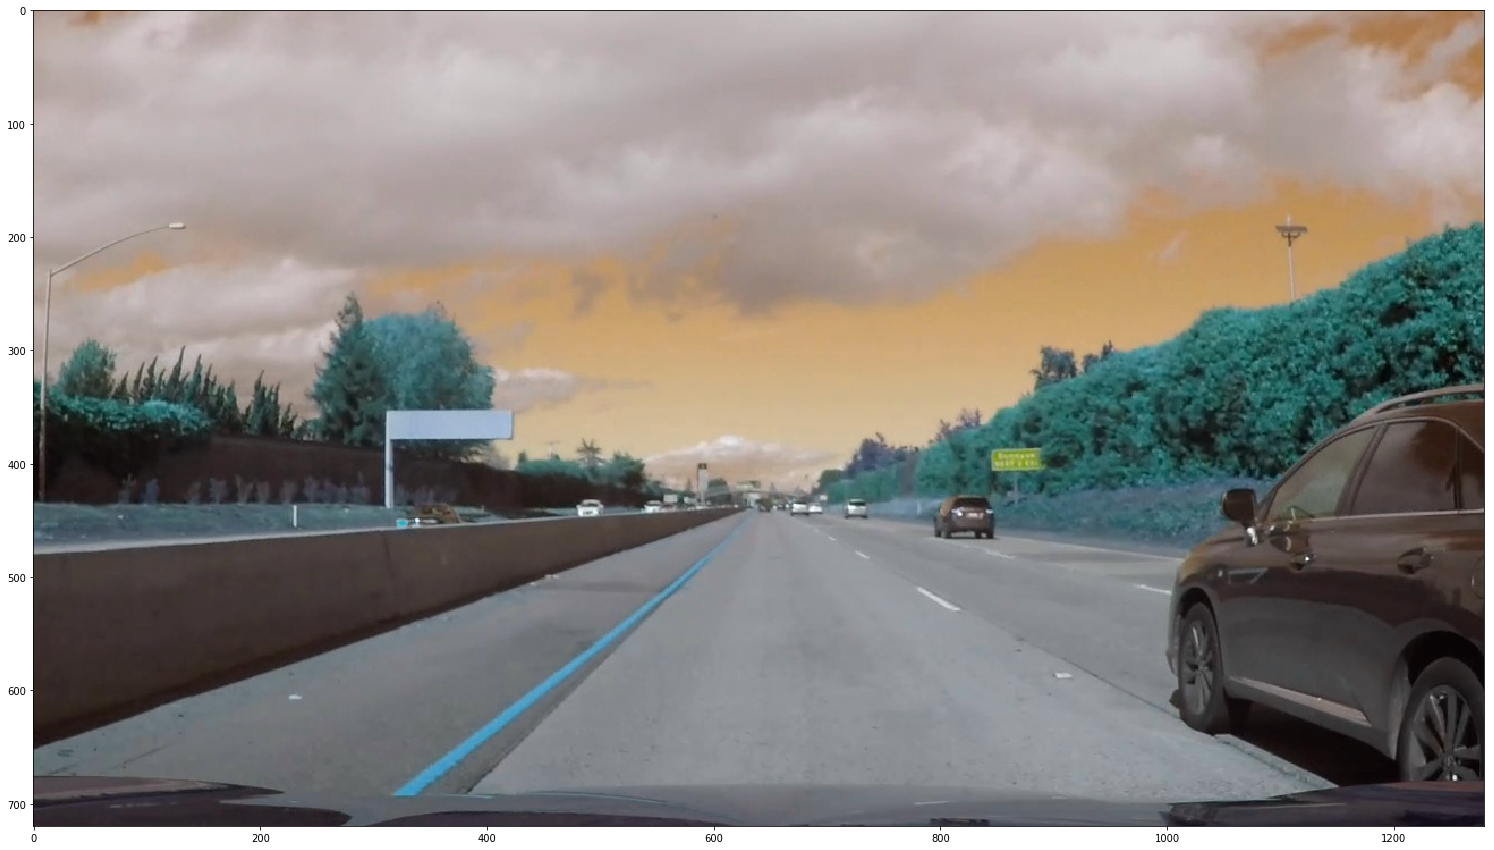

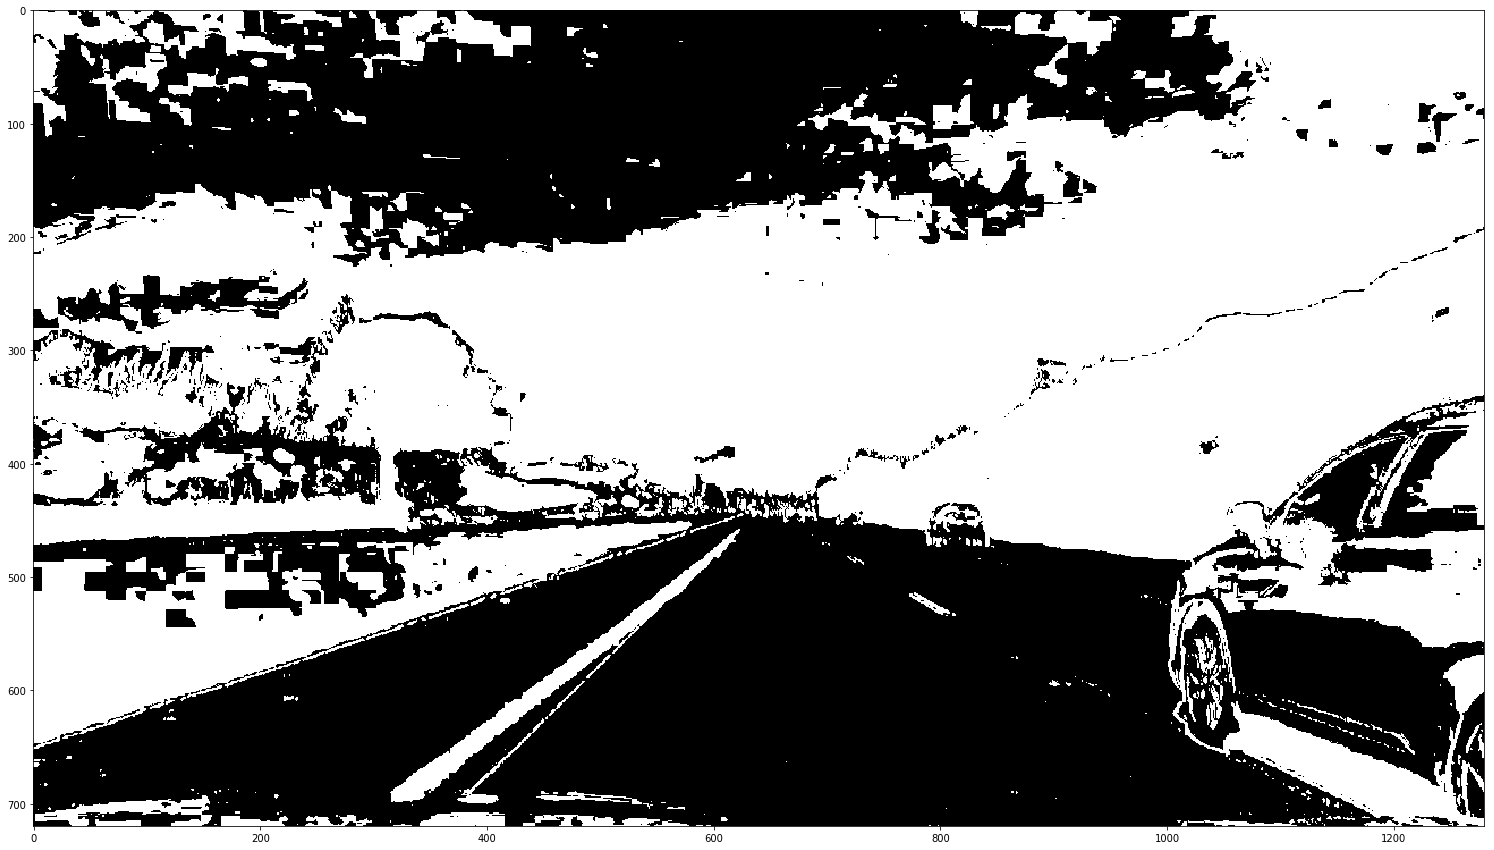

In [3]:
img = cv2.imread('dump/1490919482.0580864.jpg')

fig = plt.figure(figsize=(26, 16)) 
plt.imshow(img)
plt.show()

color_binary = preprocess_image(img, s_thresh=(25, 255), sx_thresh=(16, 255))

fig = plt.figure(figsize=(26, 16)) 
plt.imshow(color_binary, cmap='gray')
plt.show()

In [4]:
def make_paralel(img):
    img_width, img_height = (img.shape[1], img.shape[0])
    #bottom_width = 0.76
    #top_width = 0.85
    #height = 0.62
    bottom_width = 0.11
    top_width = 0.0245
    height = 0.7
    bottom_trim = 23
    src = np.float32([
    [img_width * (0.5 - top_width/2), img_height * height], 
    [img_width * (0.5 + top_width/2), img_height * height], 
    [img_width * (0.5 + bottom_width/2), img_height - bottom_trim ], 
    [img_width * (0.5 - bottom_width/2), img_height - bottom_trim ]])
    offset = img_width * 0.44
    dst = np.float32([
        [offset, 0],
        [img_width - offset, 0],
        [img_width - offset, img_height],
        [offset, img_height ]
        ]) 
    M = cv2.getPerspectiveTransform(src, dst)
    print(img.shape[1::-1])
    warped = cv2.warpPerspective(img, M,  (int(img_width), img_height))
    return warped

(1280, 720)
(720, 1280)


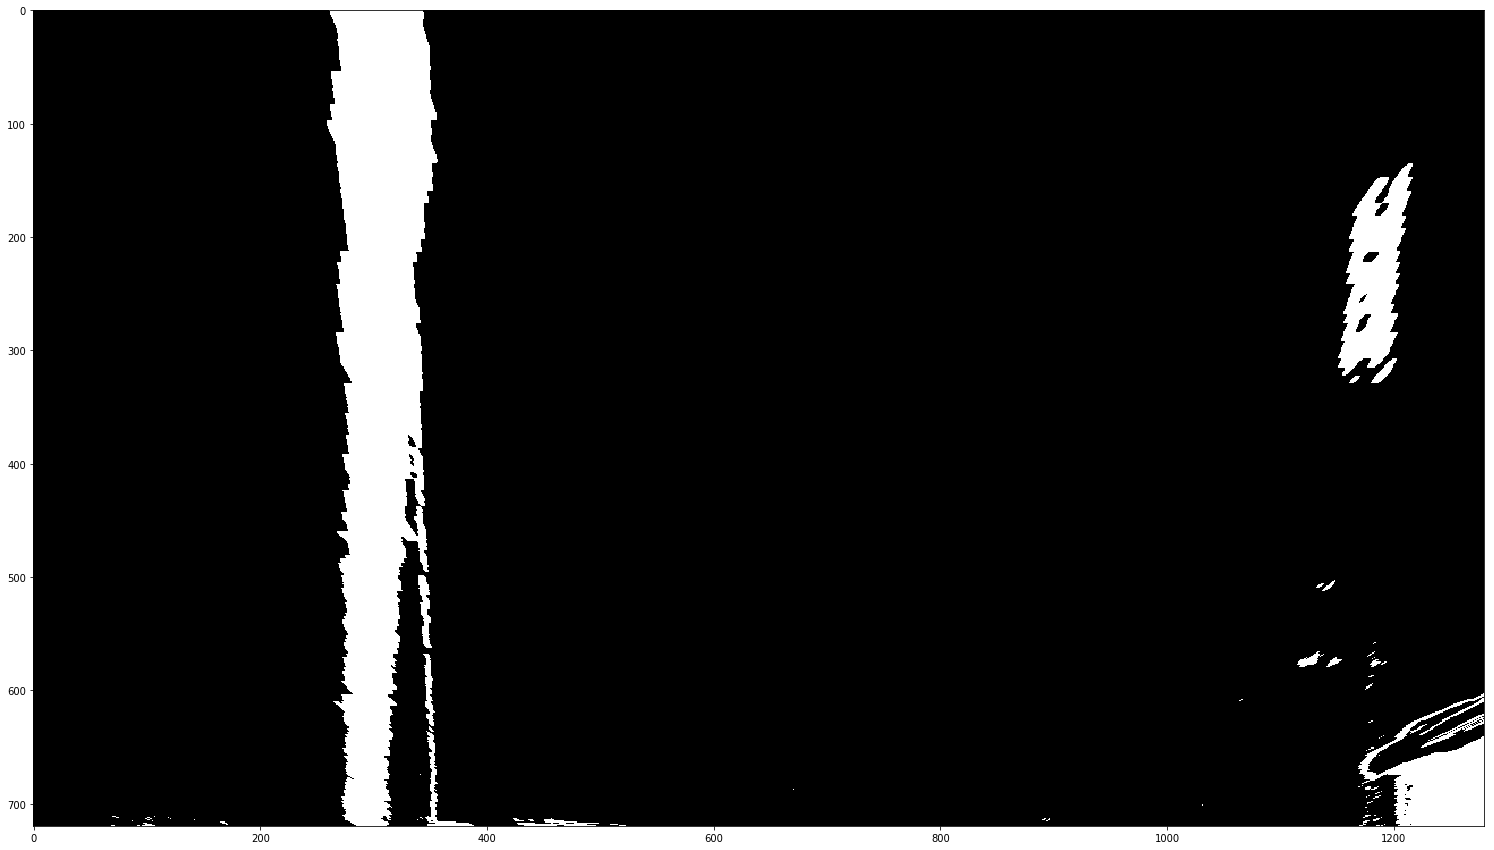

In [5]:
warped = make_paralel(color_binary)
print (warped.shape)
fig = plt.figure(figsize=(26, 16)) 
plt.imshow(warped, cmap='gray')
plt.show()

In [6]:
def histogram_based_detect_lane(binary_warped):
    #fig = plt.figure(figsize=(26, 16)) 
    #plt.imshow(binary_warped, cmap='gray')
    #plt.show()
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint]) or 0
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint or binary_warped.shape[0]

    print (histogram[50:600].shape)
    print(binary_warped.shape)
    print (leftx_base, midpoint, rightx_base)
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return out_img, left_fit, right_fit
    
def findLanesWithPrevious(binary_warped, left_fit, right_fit):
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 30
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    #visualize
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    window_img = np.zeros_like(out_img)
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return result, left_fit, right_fit

(550,)
(720, 1280)
285 640 1277


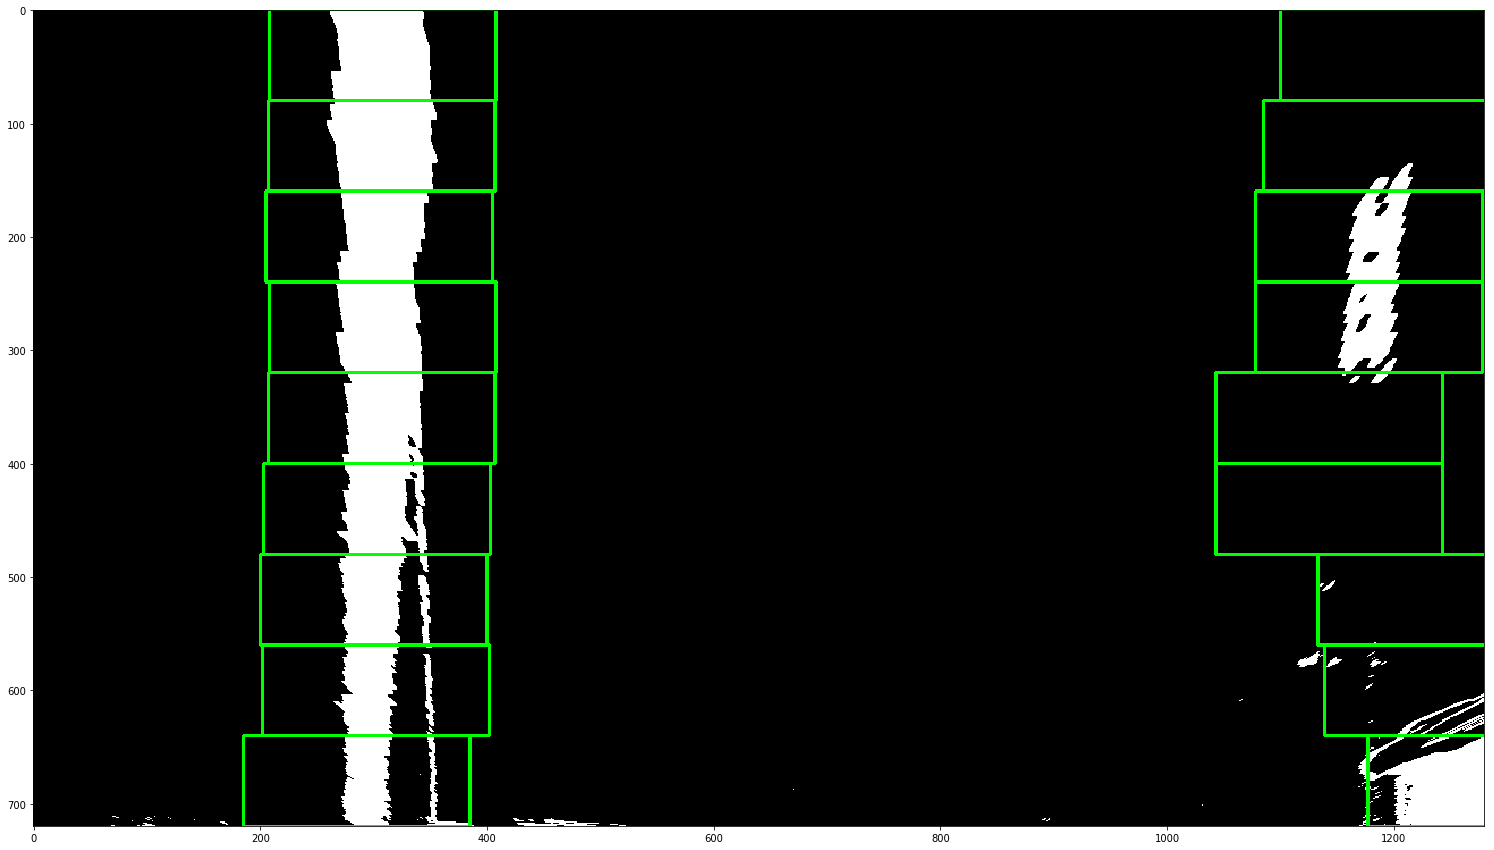

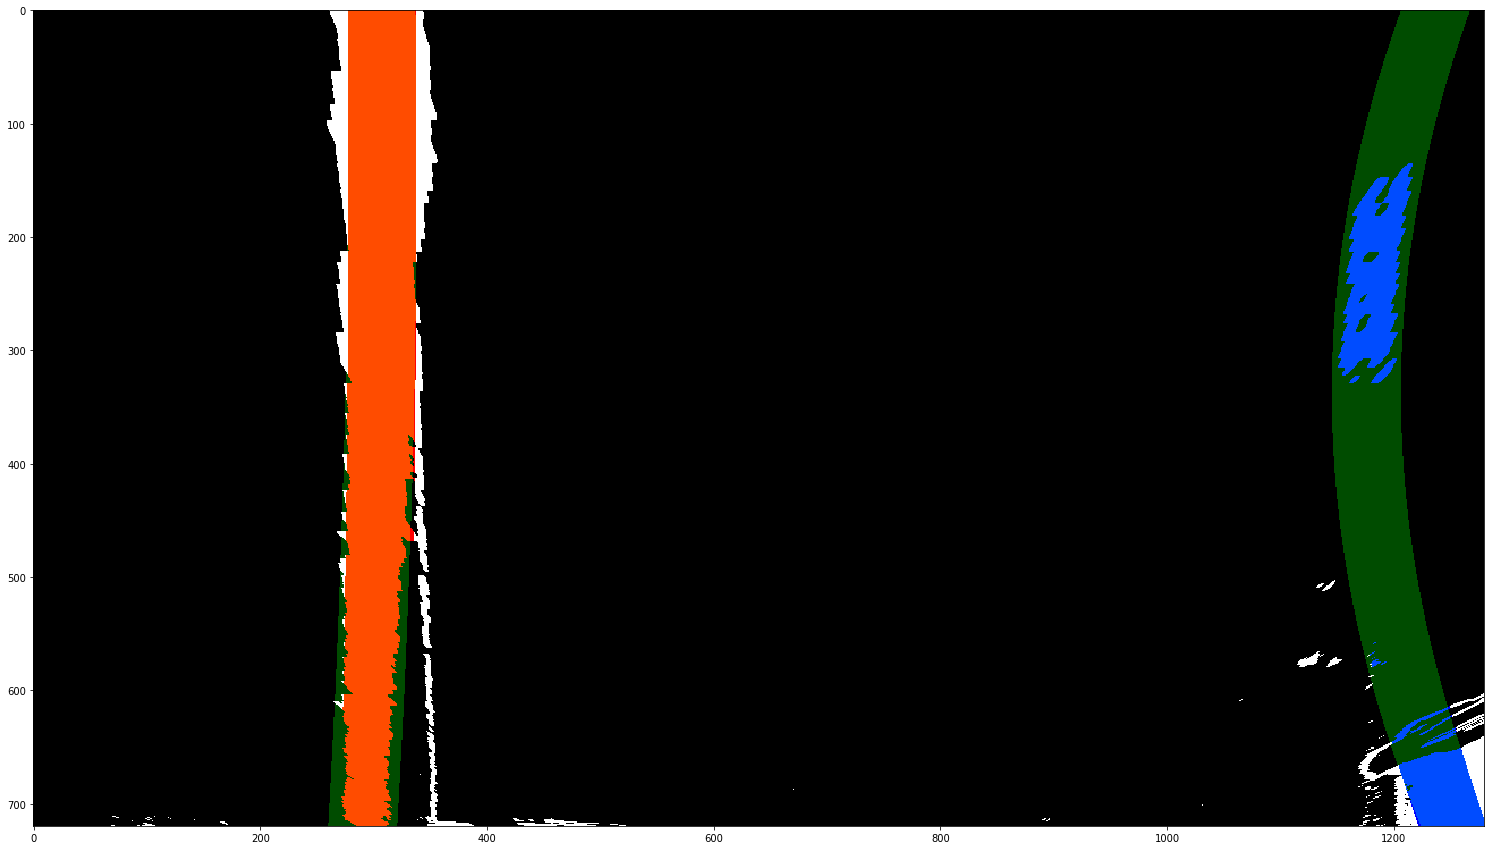

In [7]:
detected, l, r = histogram_based_detect_lane(warped)

fig = plt.figure(figsize=(26, 16)) 
plt.imshow(detected)
plt.show()

redo, l, r  = findLanesWithPrevious(warped, l, r)
fig = plt.figure(figsize=(26, 16)) 
plt.imshow(redo)
plt.show()

In [8]:
l = None
r = None

import time

def pipeline(img, l, r ):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    filename = "dump/" + str(time.time()) + ".jpg"
    cv2.imwrite(filename, hls)
    ready_to_process = make_paralel(preprocess_image(hls))
    if l is not None:
        detected, l, r = findLanesWithPrevious(ready_to_process, l, r)
    else:
        detected, l, r = histogram_based_detect_lane(ready_to_process)
    return detected

In [11]:
from moviepy.editor import VideoFileClip
white_output = 'white_notebook.mp4'
clip1 = VideoFileClip("../project_video.mp4")
white_clip = clip1.fl_image(lambda image:pipeline(image, l, r)) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

(1280, 720)
(550,)
(720, 1280)
246 640 1217
[MoviePy] >>>> Building video white_notebook.mp4
[MoviePy] Writing video white_notebook.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

(1280, 720)
(550,)
(720, 1280)
246 640 1217


  0%|          | 2/1261 [00:00<02:15,  9.29it/s]

(1280, 720)
(550,)
(720, 1280)
252 640 1214
(1280, 720)
(550,)
(720, 1280)
249 640 1216
(1280, 720)
(550,)
(720, 1280)
255 640 1206


  0%|          | 4/1261 [00:00<02:09,  9.69it/s]

(1280, 720)
(550,)
(720, 1280)
258 640 1203


  0%|          | 6/1261 [00:00<02:05, 10.01it/s]

(1280, 720)
(550,)
(720, 1280)
260 640 1208
(1280, 720)
(550,)
(720, 1280)
260 640 1210
(1280, 720)
(550,)
(720, 1280)
256 640 1203


  1%|          | 8/1261 [00:00<02:02, 10.20it/s]

(1280, 720)
(550,)
(720, 1280)
255 640 1198
(1280, 720)
(550,)
(720, 1280)
255 640 645


  1%|          | 10/1261 [00:00<02:00, 10.35it/s]

(1280, 720)
(550,)
(720, 1280)
256 640 1211


  1%|          | 12/1261 [00:01<01:58, 10.51it/s]

(1280, 720)
(550,)
(720, 1280)
255 640 1210
(1280, 720)
(550,)
(720, 1280)
254 640 1210
(1280, 720)
(550,)
(720, 1280)
248 640 1214


  1%|          | 14/1261 [00:01<01:57, 10.60it/s]

(1280, 720)
(550,)
(720, 1280)
254 640 1208
(1280, 720)
(550,)
(720, 1280)
250 640 1200


  1%|▏         | 16/1261 [00:01<01:56, 10.66it/s]

(1280, 720)
(550,)
(720, 1280)
255 640 1185


  1%|▏         | 18/1261 [00:01<01:56, 10.70it/s]

(1280, 720)
(550,)
(720, 1280)
259 640 1178
(1280, 720)
(550,)
(720, 1280)
242 640 1180
(1280, 720)
(550,)
(720, 1280)
248 640 1194


  2%|▏         | 20/1261 [00:01<01:55, 10.78it/s]

(1280, 720)
(550,)
(720, 1280)
255 640 1191
(1280, 720)
(550,)
(720, 1280)
233 640 672


  2%|▏         | 22/1261 [00:02<01:55, 10.77it/s]

(1280, 720)
(550,)
(720, 1280)
223 640 1186


  2%|▏         | 24/1261 [00:02<01:54, 10.77it/s]

(1280, 720)
(550,)
(720, 1280)
240 640 1187
(1280, 720)
(550,)
(720, 1280)
246 640 1187
(1280, 720)
(550,)
(720, 1280)
223 640 1214


  2%|▏         | 26/1261 [00:02<01:54, 10.76it/s]

(1280, 720)
(550,)
(720, 1280)
227 640 1203
(1280, 720)
(550,)
(720, 1280)
213 640 1211


  2%|▏         | 28/1261 [00:02<01:54, 10.78it/s]

(1280, 720)
(550,)
(720, 1280)
218 640 1200


  2%|▏         | 30/1261 [00:02<01:54, 10.76it/s]

(1280, 720)
(550,)
(720, 1280)
217 640 1192
(1280, 720)
(550,)
(720, 1280)
218 640 1192
(1280, 720)
(550,)
(720, 1280)
232 640 1195


  3%|▎         | 32/1261 [00:02<01:54, 10.77it/s]

(1280, 720)
(550,)
(720, 1280)
230 640 640
(1280, 720)
(550,)
(720, 1280)
230 640 1189


  3%|▎         | 34/1261 [00:03<01:53, 10.78it/s]

(1280, 720)
(550,)
(720, 1280)
226 640 662


  3%|▎         | 36/1261 [00:03<01:53, 10.82it/s]

(1280, 720)
(550,)
(720, 1280)
240 640 679
(1280, 720)
(550,)
(720, 1280)
241 640 1187
(1280, 720)
(550,)
(720, 1280)
245 640 1190


  3%|▎         | 38/1261 [00:03<01:53, 10.82it/s]

(1280, 720)
(550,)
(720, 1280)
249 640 1182
(1280, 720)
(550,)
(720, 1280)
247 640 1196


  3%|▎         | 40/1261 [00:03<01:52, 10.85it/s]

(1280, 720)
(550,)
(720, 1280)
238 640 1193


  3%|▎         | 42/1261 [00:03<01:52, 10.83it/s]

(1280, 720)
(550,)
(720, 1280)
241 640 1185
(1280, 720)
(550,)
(720, 1280)
241 640 1185
(1280, 720)
(550,)
(720, 1280)
241 640 1190


  3%|▎         | 44/1261 [00:04<01:52, 10.82it/s]

(1280, 720)
(550,)
(720, 1280)
251 640 1199
(1280, 720)
(550,)
(720, 1280)
244 640 1190


  4%|▎         | 46/1261 [00:04<01:52, 10.79it/s]

(1280, 720)
(550,)
(720, 1280)
248 640 1187


  4%|▍         | 48/1261 [00:04<01:52, 10.79it/s]

(1280, 720)
(550,)
(720, 1280)
243 640 1182
(1280, 720)
(550,)
(720, 1280)
248 640 1195
(1280, 720)
(550,)
(720, 1280)
250 640 1199


  4%|▍         | 50/1261 [00:04<01:52, 10.78it/s]

(1280, 720)
(550,)
(720, 1280)
230 640 1214
(1280, 720)
(550,)
(720, 1280)
243 640 1200


  4%|▍         | 52/1261 [00:04<01:52, 10.79it/s]

(1280, 720)
(550,)
(720, 1280)
242 640 1197


  4%|▍         | 54/1261 [00:05<01:51, 10.79it/s]

(1280, 720)
(550,)
(720, 1280)
238 640 1191
(1280, 720)
(550,)
(720, 1280)
243 640 1185


  4%|▍         | 56/1261 [00:05<01:50, 10.86it/s]

(1280, 720)
(550,)
(720, 1280)
226 640 1179
(1280, 720)
(550,)
(720, 1280)
223 640 1191
(1280, 720)
(550,)
(720, 1280)
235 640 1185


  5%|▍         | 58/1261 [00:05<01:52, 10.71it/s]

(1280, 720)
(550,)
(720, 1280)
224 640 642


  5%|▍         | 60/1261 [00:05<01:52, 10.65it/s]

(1280, 720)
(550,)
(720, 1280)
229 640 645
(1280, 720)
(550,)
(720, 1280)
240 640 1191
(1280, 720)
(550,)
(720, 1280)
241 640 1164


  5%|▍         | 62/1261 [00:05<01:52, 10.63it/s]

(1280, 720)
(550,)
(720, 1280)
230 640 1183
(1280, 720)
(550,)
(720, 1280)
227 640 1182


  5%|▌         | 64/1261 [00:05<01:53, 10.53it/s]

(1280, 720)
(550,)
(720, 1280)
225

  5%|▌         | 66/1261 [00:06<01:52, 10.59it/s]

 640 1180
(1280, 720)
(550,)
(720, 1280)
236 640 1170
(1280, 720)
(550,)
(720, 1280)
236 640 1170
(1280, 720)
(550,)
(720, 1280)
232 640 1165


  6%|▌         | 70/1261 [00:06<01:50, 10.77it/s]

(1280, 720)
(550,)
(720, 1280)
218 640 1162
(1280, 720)
(550,)
(720, 1280)
210 640 1166
(1280, 720)
(550,)
(720, 1280)
211 640 645


  6%|▌         | 72/1261 [00:06<01:50, 10.75it/s]

(1280, 720)
(550,)
(720, 1280)
217 640 1160
(1280, 720)
(550,)
(720, 1280)
219 640 648
(1280, 720)
(550,)
(720, 1280)
221 640 1152


  6%|▌         | 74/1261 [00:06<01:50, 10.76it/s]

(1280, 720)
(550,)
(720, 1280)
223 640 1177
(1280, 720)
(550,)
(720, 1280)
215 640 1157


  6%|▌         | 76/1261 [00:07<01:50, 10.68it/s]

(1280, 720)
(550,)
(720, 1280)
211 640 1170


  6%|▌         | 78/1261 [00:07<01:50, 10.75it/s]

(1280, 720)
(550,)
(720, 1280)
220 640 1174
(1280, 720)
(550,)
(720, 1280)
192 640 1168
(1280, 720)
(550,)
(720, 1280)
205 640 1153


  6%|▋         | 80/1261 [00:07<01:49, 10.75it/s]

(1280, 720)
(550,)
(720, 1280)
207 640 1151
(1280, 720)
(550,)
(720, 1280)
196 640 1149


  7%|▋         | 82/1261 [00:07<01:49, 10.76it/s]

(1280, 720)
(550,)
(720, 1280)
186 640 1179


  7%|▋         | 84/1261 [00:07<01:49, 10.75it/s]

(1280, 720)
(550,)
(720, 1280)
179 640 1164
(1280, 720)
(550,)
(720, 1280)
180 640 1158
(1280, 720)


  7%|▋         | 86/1261 [00:08<01:51, 10.56it/s]

(550,)
(720, 1280)
175 640 1149
(1280, 720)
(550,)
(720, 1280)
192 640 1169
(1280, 720)
(550,)
(720, 1280)

  7%|▋         | 88/1261 [00:08<01:52, 10.43it/s]


201 640 1159
(1280, 720)
(550,)
(720, 1280)
192 640 1169
(1280, 720)
(550,)
(720, 1280)
205 640 1162


  7%|▋         | 90/1261 [00:08<01:51, 10.50it/s]

(1280, 720)
(550,)
(720, 1280)
203 640 1160


  7%|▋         | 92/1261 [00:08<01:50, 10.57it/s]

(1280, 720)
(550,)
(720, 1280)
206 640 1158
(1280, 720)
(550,)
(720, 1280)
209 640 1151
(1280, 720)
(550,)
(720, 1280)
204 640 1159


  7%|▋         | 94/1261 [00:08<01:50, 10.56it/s]

(1280, 720)
(550,)
(720, 1280)
210 640 1155
(1280, 720)
(550,)
(720, 1280)
206 640 1153


  8%|▊         | 96/1261 [00:08<01:49, 10.60it/s]

(1280, 720)
(550,)
(720, 1280)
209 640 645


  8%|▊         | 98/1261 [00:09<01:48, 10.67it/s]

(1280, 720)
(550,)
(720, 1280)
210 640 677
(1280, 720)
(550,)
(720, 1280)
214 640 1155
(1280, 720)
(550,)
(720, 1280)
216 640 1153


  8%|▊         | 100/1261 [00:09<01:49, 10.65it/s]

(1280, 720)
(550,)
(720, 1280)
215 640 1159
(1280, 720)
(550,)
(720, 1280)
212 640 1153


  8%|▊         | 102/1261 [00:09<01:48, 10.66it/s]

(1280, 720)
(550,)
(720, 1280)
218 640 1159


  8%|▊         | 104/1261 [00:09<01:48, 10.70it/s]

(1280, 720)
(550,)
(720, 1280)
211 640 1157
(1280, 720)
(550,)
(720, 1280)
217 640 1155
(1280, 720)
(550,)
(720, 1280)
215 640 1149


  8%|▊         | 106/1261 [00:09<01:48, 10.61it/s]

(1280, 720)
(550,)
(720, 1280)
212 640 1147
(1280, 720)
(550,)
(720, 1280)
225 640 1165


  9%|▊         | 108/1261 [00:10<01:48, 10.66it/s]

(1280, 720)
(550,)
(720, 1280)
226 640 1173


  9%|▊         | 110/1261 [00:10<01:47, 10.67it/s]

(1280, 720)
(550,)
(720, 1280)
219 640 645
(1280, 720)
(550,)
(720, 1280)
218 640 1164
(1280, 720)
(550,)
(720, 1280)
226 640 1181


  9%|▉         | 112/1261 [00:10<01:47, 10.67it/s]

(1280, 720)
(550,)
(720, 1280)
226 640 1179
(1280, 720)
(550,)

  9%|▉         | 114/1261 [00:10<01:48, 10.57it/s]


(720, 1280)
219 640 1187
(1280, 720)
(550,)
(720, 1280)
224 

  9%|▉         | 116/1261 [00:10<01:48, 10.59it/s]

640 1186
(1280, 720)
(550,)
(720, 1280)
227 640 1176
(1280, 720)
(550,)
(720, 1280)
227 640 1177
(1280, 720)
(550,)
(720, 1280)
232 640 1170


  9%|▉         | 118/1261 [00:11<01:48, 10.58it/s]

(1280, 720)
(550,)
(720, 1280)
236 640 1172
(1280, 720)
(550,)
(720, 1280)
238 640 1172


 10%|▉         | 120/1261 [00:11<01:46, 10.67it/s]

(1280, 720)
(550,)
(720, 1280)
235 640 1176


 10%|▉         | 122/1261 [00:11<01:47, 10.57it/s]

(1280, 720)
(550,)
(720, 1280)
244 640 1176
(1280, 720)
(550,)
(720, 1280)
245 640 1169
(1280, 720)
(550,)
(720, 1280)
248 640 1164


 10%|▉         | 124/1261 [00:11<01:47, 10.61it/s]

(1280, 720)
(550,)
(720, 1280)
247 640 1179
(1280, 720)
(550,)
(720, 1280)
244 640 1184


 10%|▉         | 126/1261 [00:11<01:46, 10.62it/s]

(1280, 720)
(550,)
(720, 1280)
243 640 1195


 10%|█         | 128/1261 [00:11<01:47, 10.58it/s]

(1280, 720)
(550,)
(720, 1280)
243 640 1199
(1280, 720)
(550,)
(720, 1280)
247 640 1187
(1280, 720)
(550,)
(720, 1280)
253 640 1186


 10%|█         | 132/1261 [00:12<01:45, 10.67it/s]

(1280, 720)
(550,)
(720, 1280)
252 640 1177
(1280, 720)
(550,)
(720, 1280)
255 640 1183
(1280, 720)
(550,)
(720, 1280)
252 640 1182


 11%|█         | 134/1261 [00:12<01:46, 10.55it/s]

(1280, 720)
(550,)
(720, 1280)
252 640 1179
(1280, 720)
(550,)
(720, 1280)
252 640 1178
(1280, 720)
(550,)
(720, 1280)
262 640 677


 11%|█         | 136/1261 [00:12<01:46, 10.60it/s]

(1280, 720)
(550,)
(720, 1280)
262 640 1188


 11%|█         | 138/1261 [00:12<01:45, 10.61it/s]

(1280, 720)
(550,)
(720, 1280)
247 640 1193
(1280, 720)
(550,)
(720, 1280)
257 640 1219
(1280, 720)
(550,)
(720, 1280)
248 640 1213


 11%|█         | 140/1261 [00:13<01:45, 10.63it/s]

(1280, 720)
(550,)
(720, 1280)
248 640 1205
(1280, 720)
(550,)
(720, 1280)
240 640 1201


 11%|█▏        | 142/1261 [00:13<01:44, 10.68it/s]

(1280, 720)
(550,)
(720, 1280)
242 640 1189


 11%|█▏        | 144/1261 [00:13<01:44, 10.70it/s]

(1280, 720)
(550,)
(720, 1280)
238 640 1179
(1280, 720)
(550,)
(720, 1280)
237 640 1198
(1280, 720)
(550,)
(720, 1280)
238 640 1191


 12%|█▏        | 146/1261 [00:13<01:44, 10.67it/s]

(1280, 720)
(550,)
(720, 1280)
241 640 657
(1280, 720)
(550,)
(720, 1280)
256 640 671


 12%|█▏        | 148/1261 [00:13<01:43, 10.75it/s]

(1280, 720)
(550,)
(720, 1280)
255 640 677


 12%|█▏        | 150/1261 [00:14<01:43, 10.78it/s]

(1280, 720)
(550,)
(720, 1280)
264 640 1183
(1280, 720)
(550,)
(720, 1280)
251 640 1187
(1280, 720)
(550,)


 12%|█▏        | 152/1261 [00:14<01:44, 10.64it/s]

(720, 1280)
246 640 1184
(1280, 720)
(550,)
(720, 1280)
244 640 1187
(1280, 720)
(550,)
(720, 1280)
241 640 1197


 12%|█▏        | 154/1261 [00:14<01:44, 10.56it/s]

(1280, 720)


 12%|█▏        | 156/1261 [00:14<01:44, 10.54it/s]

(550,)
(720, 1280)
240 640 1188
(1280, 720)
(550,)
(720, 1280)
240 640 1190
(1280, 720)
(550,)
(720, 1280)
230 640 1185


 13%|█▎        | 158/1261 [00:14<01:44, 10.60it/s]

(1280, 720)
(550,)
(720, 1280)
223 640 1180
(1280, 720)
(550,)
(720, 1280)
230 640 659
(1280, 720)
(550,)
(720, 1280)
226 640 659


 13%|█▎        | 162/1261 [00:15<01:42, 10.69it/s]

(1280, 720)
(550,)
(720, 1280)
223 640 649
(1280, 720)
(550,)
(720, 1280)
239 640 1183
(1280, 720)
(550,)
(720, 1280)
216 640 1187


 13%|█▎        | 164/1261 [00:15<01:42, 10.69it/s]

(1280, 720)
(550,)
(720, 1280)
217 640 1181
(1280, 720)
(550,)
(720, 1280)
220 640 1175
(1280, 720)
(550,)
(720, 1280)
217 640 1176


 13%|█▎        | 168/1261 [00:15<01:41, 10.78it/s]

(1280, 720)
(550,)
(720, 1280)
218 640 1179
(1280, 720)
(550,)
(720, 1280)
215 640 1168
(1280, 720)
(550,)
(720, 1280)
210 640 1184


 13%|█▎        | 170/1261 [00:15<01:41, 10.80it/s]

(1280, 720)
(550,)
(720, 1280)
216 640 1184
(1280, 720)
(550,)
(720, 1280)
215 640 1177
(1280, 720)
(550,)
(720, 1280)
216 640 656


 14%|█▍        | 174/1261 [00:16<01:41, 10.72it/s]

(1280, 720)
(550,)
(720, 1280)
211 640 649
(1280, 720)
(550,)
(720, 1280)
215 640 1168
(1280, 720)
(550,)
(720, 1280)
223 640 1163


 14%|█▍        | 176/1261 [00:16<01:41, 10.69it/s]

(1280, 720)
(550,)
(720, 1280)
211 640 1180
(1280, 720)
(550,)
(720, 1280)
207 640 1175
(1280, 720)
(550,)
(720, 1280)
208 640 1182


 14%|█▍        | 180/1261 [00:16<01:42, 10.57it/s]

(1280, 720)
(550,)
(720, 1280)
199 640 1182
(1280, 720)
(550,)
(720, 1280)
198 640 1177
(1280, 720)
(550,)
(720, 1280)
202 640 1173


 14%|█▍        | 182/1261 [00:17<01:43, 10.46it/s]

(1280, 720)
(550,)
(720, 1280)
202 640 1171
(1280, 720)
(550,)
(720, 1280)
204 640 1182
(1280, 720)
(550,)
(720, 1280)
201 640 1182


 15%|█▍        | 186/1261 [00:17<01:41, 10.60it/s]

(1280, 720)
(550,)
(720, 1280)
201 640 660
(1280, 720)
(550,)
(720, 1280)
222 640 1160
(1280, 720)
(550,)
(720, 1280)
218 640 1187


 15%|█▌        | 190/1261 [00:17<01:39, 10.75it/s]

(1280, 720)
(550,)
(720, 1280)
221 640 1185
(1280, 720)
(550,)
(720, 1280)
220 640 1182
(1280, 720)
(550,)
(720, 1280)
223 640 1180


 15%|█▌        | 192/1261 [00:17<01:39, 10.76it/s]

(1280, 720)
(550,)
(720, 1280)
229 640 1171
(1280, 720)
(550,)
(720, 1280)
232 640 1170
(1280, 720)
(550,)
(720, 1280)
236 640 1166


 15%|█▌        | 194/1261 [00:18<01:39, 10.78it/s]

(1280, 720)
(550,)
(720, 1280)
240 640 1167
(1280, 720)
(550,)
(720, 1280)
237 640 1172
(1280, 720)
(550,)
(720, 1280)
227 640 730


 16%|█▌        | 198/1261 [00:18<01:38, 10.81it/s]

(1280, 720)
(550,)
(720, 1280)
228 640 681
(1280, 720)
(550,)
(720, 1280)
232 640 658
(1280, 720)
(550,)
(720, 1280)
225 640 1202


 16%|█▌        | 200/1261 [00:18<01:38, 10.77it/s]

(1280, 720)
(550,)
(720, 1280)
228 640 1195
(1280, 720)
(550,)
(720, 1280)
226 640 1195
(1280, 720)
(550,)
(720, 1280)
218 640 1203


 16%|█▌        | 204/1261 [00:19<01:38, 10.71it/s]

(1280, 720)
(550,)
(720, 1280)
205 640 1194
(1280, 720)
(550,)
(720, 1280)
196 640 1189
(1280, 720)
(550,)


 16%|█▋        | 206/1261 [00:19<01:39, 10.62it/s]

(720, 1280)
202 640 1176
(1280, 720)
(550,)
(720, 1280)
204 640 1172
(1280, 720)
(550,)
(720, 1280)
210 640 1173
(1280, 720)
(550,)
(720, 1280)
215 640 690


 17%|█▋        | 210/1261 [00:19<01:38, 10.71it/s]

(1280, 720)
(550,)
(720, 1280)
227 640 689
(1280, 720)
(550,)
(720, 1280)
215 640 649
(1280, 720)
(550,)
(720, 1280)
215 640 689


 17%|█▋        | 212/1261 [00:19<01:38, 10.67it/s]

(1280, 720)
(550,)
(720, 1280)
222 640 1180
(1280, 720)
(550,)
(720, 1280)
212 640 1188
(1280, 720)
(550,)
(720, 1280)
213 640 1195


 17%|█▋        | 216/1261 [00:20<01:37, 10.72it/s]

(1280, 720)
(550,)
(720, 1280)
208 640 1180
(1280, 720)
(550,)
(720, 1280)
205 640 1182
(1280, 720)
(550,)
(720, 1280)
204 640 1170


 17%|█▋        | 218/1261 [00:20<01:37, 10.73it/s]

(1280, 720)
(550,)
(720, 1280)
201 640 1161
(1280, 720)
(550,)
(720, 1280)
202 640 1163
(1280, 720)
(550,)
(720, 1280)
215 640 1167


 18%|█▊        | 222/1261 [00:20<01:36, 10.72it/s]

(1280, 720)
(550,)
(720, 1280)
215 640 1169
(1280, 720)
(550,)
(720, 1280)
194 640 1161
(1280, 720)
(550,)
(720, 1280)
207 640 720


 18%|█▊        | 224/1261 [00:20<01:36, 10.76it/s]

(1280, 720)
(550,)
(720, 1280)
229 640 1154
(1280, 720)
(550,)
(720, 1280)
200 640 1178
(1280, 720)
(550,)
(720, 1280)
194 640 1151


 18%|█▊        | 228/1261 [00:21<01:36, 10.71it/s]

(1280, 720)
(550,)
(720, 1280)
196 640 1154
(1280, 720)
(550,)
(720, 1280)
196 640 1146
(1280, 720)
(550,)
(720, 1280)
196 640 1146


 18%|█▊        | 230/1261 [00:21<01:36, 10.72it/s]

(1280, 720)
(550,)
(720, 1280)
194 640 1152
(1280, 720)
(550,)
(720, 1280)
202 640 1147
(1280, 720)
(550,)
(720, 1280)
184 640 1146


 19%|█▊        | 234/1261 [00:21<01:36, 10.68it/s]

(1280, 720)
(550,)
(720, 1280)
192 640 722
(1280, 720)
(550,)
(720, 1280)
180 640 726
(1280, 720)
(550,)
(720, 1280)
186 640 720


 19%|█▊        | 236/1261 [00:22<01:35, 10.77it/s]

(1280, 720)
(550,)
(720, 1280)
196 640 1131
(1280, 720)
(550,)
(720, 1280)
175 640 1140
(1280, 720)
(550,)
(720, 1280)
175 640 1134


 19%|█▉        | 240/1261 [00:22<01:34, 10.77it/s]

(1280, 720)
(550,)
(720, 1280)
175 640 1143
(1280, 720)
(550,)
(720, 1280)
177 640 1129
(1280, 720)
(550,)
(720, 1280)
177 640 1130


 19%|█▉        | 242/1261 [00:22<01:34, 10.73it/s]

(1280, 720)
(550,)
(720, 1280)
167 640 1131
(1280, 720)
(550,)
(720, 1280)
169 640 1132
(1280, 720)
(550,)
(720, 1280)
169 640 1132


 20%|█▉        | 246/1261 [00:23<01:34, 10.70it/s]

(1280, 720)
(550,)
(720, 1280)
170 640 696
(1280, 720)
(550,)
(720, 1280)
169 640 701
(1280, 720)
(550,)
(720, 1280)
173 640 650


 20%|█▉        | 248/1261 [00:23<01:35, 10.57it/s]

(1280, 720)
(550,)
(720, 1280)
187 640 1117
(1280, 720)
(550,)
(720, 1280)
159 640 1121
(1280, 720)
(550,)
(720, 1280)
177 640 1121


 20%|█▉        | 252/1261 [00:23<01:34, 10.67it/s]

(1280, 720)
(550,)
(720, 1280)
166 640 1131
(1280, 720)
(550,)
(720, 1280)
161 640 1136
(1280, 720)
(550,)
(720, 1280)
159 640 1136


 20%|██        | 254/1261 [00:23<01:35, 10.51it/s]

(1280, 720)
(550,)
(720, 1280)
159 640 1129
(1280, 720)
(550,)
(720, 1280)
163 640 1127
(1280, 720)
(550,)
(720, 1280)
162 640 1136


 20%|██        | 258/1261 [00:24<01:34, 10.61it/s]

(1280, 720)
(550,)
(720, 1280)
167 640 1073
(1280, 720)
(550,)
(720, 1280)
171 640 1068
(1280, 720)
(550,)
(720, 1280)
181 640 1068


 21%|██        | 260/1261 [00:24<01:34, 10.60it/s]

(1280, 720)
(550,)
(720, 1280)
185 640 1112
(1280, 720)
(550,)
(720, 1280)
179 640 1148
(1280, 720)
(550,)
(720, 1280)
182 640 1139


 21%|██        | 264/1261 [00:24<01:34, 10.58it/s]

(1280, 720)
(550,)
(720, 1280)
185 640 1138
(1280, 720)
(550,)
(720, 1280)
186 640 1155
(1280, 720)
(550,)
(720, 1280)
170 640 1145


 21%|██        | 266/1261 [00:24<01:34, 10.48it/s]

(1280, 720)
(550,)
(720, 1280)
182 640 1146
(1280, 720)
(550,)
(720, 1280)
168 640 1142
(1280, 720)
(550,)
(720, 1280)
169 640 1150


 21%|██▏       | 270/1261 [00:25<01:34, 10.52it/s]

(1280, 720)
(550,)
(720, 1280)
171 640 1151
(1280, 720)
(550,)
(720, 1280)
175 640 686
(1280, 720)
(550,)
(720, 1280)
175 640 692


 22%|██▏       | 272/1261 [00:25<01:33, 10.57it/s]

(1280, 720)
(550,)
(720, 1280)
193 640 1160
(1280, 720)
(550,)
(720, 1280)
184 640 1151
(1280, 720)
(550,)
(720, 1280)
187 640 1147


 22%|██▏       | 276/1261 [00:25<01:32, 10.61it/s]

(1280, 720)
(550,)
(720, 1280)
188 640 1150
(1280, 720)
(550,)
(720, 1280)
187 640 1160
(1280, 720)
(550,)
(720, 1280)
187 640 1155


 22%|██▏       | 278/1261 [00:26<01:32, 10.63it/s]

(1280, 720)
(550,)
(720, 1280)
187 640 1151
(1280, 720)
(550,)
(720, 1280)
192 640 1154
(1280, 720)
(550,)
(720, 1280)
192 640 1156


 22%|██▏       | 282/1261 [00:26<01:31, 10.66it/s]

(1280, 720)
(550,)
(720, 1280)
190 640 1158
(1280, 720)
(550,)
(720, 1280)
199 640 640
(1280, 720)
(550,)
(720, 1280)
205 640 702


 23%|██▎       | 284/1261 [00:26<01:31, 10.71it/s]

(1280, 720)
(550,)
(720, 1280)
208 640 1166
(1280, 720)
(550,)
(720, 1280)
204 640 1170
(1280, 720)
(550,)
(720, 1280)
203 640 1187


 23%|██▎       | 288/1261 [00:26<01:31, 10.65it/s]

(1280, 720)
(550,)
(720, 1280)
207 640 1179
(1280, 720)
(550,)
(720, 1280)
208 640 1181
(1280, 720)
(550,)
(720, 1280)
206 640 1170


 23%|██▎       | 290/1261 [00:27<01:31, 10.66it/s]

(1280, 720)
(550,)
(720, 1280)
212 640 1159
(1280, 720)
(550,)
(720, 1280)
210 640 1148
(1280, 720)
(550,)
(720, 1280)
215 640 1173


 23%|██▎       | 294/1261 [00:27<01:30, 10.70it/s]

(1280, 720)
(550,)
(720, 1280)
216 640 1173
(1280, 720)
(550,)
(720, 1280)
218 640 657
(1280, 720)
(550,)
(720, 1280)
219 640 690


 23%|██▎       | 296/1261 [00:27<01:30, 10.70it/s]

(1280, 720)
(550,)
(720, 1280)
220 640 1180
(1280, 720)
(550,)
(720, 1280)
221 640 1178
(1280, 720)
(550,)
(720, 1280)
217 640 1177


 24%|██▍       | 300/1261 [00:28<01:30, 10.67it/s]

(1280, 720)
(550,)
(720, 1280)
220 640 1184
(1280, 720)
(550,)
(720, 1280)
214 640 1182
(1280, 720)
(550,)
(720, 1280)
210 640 1179


 24%|██▍       | 302/1261 [00:28<01:29, 10.66it/s]

(1280, 720)
(550,)
(720, 1280)
207 640 1178
(1280, 720)
(550,)
(720, 1280)
215 640 1175
(1280, 720)
(550,)
(720, 1280)
214 640 1179


 24%|██▍       | 306/1261 [00:28<01:29, 10.65it/s]

(1280, 720)
(550,)
(720, 1280)
212 640 685
(1280, 720)
(550,)
(720, 1280)
215 640 1173
(1280, 720)
(550,)
(720, 1280)
212 640 718


 24%|██▍       | 308/1261 [00:28<01:29, 10.68it/s]

(1280, 720)
(550,)
(720, 1280)
222 640 1183
(1280, 720)
(550,)
(720, 1280)
220 640 1183
(1280, 720)
(550,)
(720, 1280)
220 640 1183


 25%|██▍       | 312/1261 [00:29<01:28, 10.68it/s]

(1280, 720)
(550,)
(720, 1280)
222 640 1187
(1280, 720)
(550,)
(720, 1280)
226 640 1180
(1280, 720)
(550,)
(720, 1280)
226 640 1170


 25%|██▍       | 314/1261 [00:29<01:28, 10.74it/s]

(1280, 720)
(550,)
(720, 1280)
226 640 1163
(1280, 720)
(550,)
(720, 1280)
227 640 1153
(1280, 720)
(550,)
(720, 1280)
226 640 1174


 25%|██▌       | 318/1261 [00:29<01:27, 10.73it/s]

(1280, 720)
(550,)
(720, 1280)
229 640 1185
(1280, 720)
(550,)
(720, 1280)
234 640 1124
(1280, 720)


 25%|██▌       | 320/1261 [00:29<01:29, 10.57it/s]

(550,)
(720, 1280)
234 640 1160
(1280, 720)
(550,)
(720, 1280)
240 640 1175
(1280, 720)
(550,)
(720, 1280)
234 640 1177


 26%|██▌       | 322/1261 [00:30<01:28, 10.60it/s]

(1280, 720)
(550,)
(720, 1280)
234 640 1189
(1280, 720)
(550,)
(720, 1280)
235 640 1187
(1280, 720)
(550,)
(720, 1280)
230 640 1183


 26%|██▌       | 326/1261 [00:30<01:27, 10.65it/s]

(1280, 720)
(550,)
(720, 1280)
235 640 1172
(1280, 720)
(550,)
(720, 1280)
234 640 1169
(1280, 720)
(550,)
(720, 1280)
231 640 1172


 26%|██▌       | 328/1261 [00:30<01:27, 10.68it/s]

(1280, 720)
(550,)
(720, 1280)
230 640 1173
(1280, 720)
(550,)
(720, 1280)
230 640 1194
(1280, 720)
(550,)
(720, 1280)
227 640 674


 26%|██▋       | 332/1261 [00:31<01:28, 10.55it/s]

(1280, 720)
(550,)
(720, 1280)
226 640 689
(1280, 720)
(550,)
(720, 1280)
232 640 1186
(1280, 720)


 26%|██▋       | 334/1261 [00:31<01:28, 10.44it/s]

(550,)
(720, 1280)
235 640 1182
(1280, 720)
(550,)
(720, 1280)
235 640 1193
(1280, 720)
(550,)
(720, 1280)
237 640 1187
(1280, 720)
(550,)
(720, 1280)
230 640 1194


 27%|██▋       | 338/1261 [00:31<01:27, 10.60it/s]

(1280, 720)
(550,)
(720, 1280)
230 640 1184
(1280, 720)
(550,)
(720, 1280)
230 640 1182
(1280, 720)
(550,)
(720, 1280)
232 640 1174


 27%|██▋       | 340/1261 [00:31<01:26, 10.63it/s]

(1280, 720)
(550,)
(720, 1280)
234 640 1180
(1280, 720)
(550,)
(720, 1280)
240 640 1196
(1280, 720)
(550,)
(720, 1280)
240 640 651


 27%|██▋       | 344/1261 [00:32<01:27, 10.50it/s]

(1280, 720)
(550,)
(720, 1280)
239 640 670
(1280, 720)
(550,)
(720, 1280)
238 640 1189
(1280, 720)
(550,)
(720, 1280)

 27%|██▋       | 346/1261 [00:32<01:26, 10.54it/s]


238 640 1189
(1280, 720)
(550,)
(720, 1280)
238 640 1201
(1280, 720)
(550,)
(720, 1280)
235 640 1192
(1280, 720)
(550,)
(720, 1280)
232 640 1195


 28%|██▊       | 350/1261 [00:32<01:26, 10.54it/s]

(1280, 720)
(550,)
(720, 1280)
235 640 1186
(1280, 720)
(550,)
(720, 1280)
233 640 1182
(1280, 720)
(550,)
(720, 1280)
234 640 1164


 28%|██▊       | 352/1261 [00:33<01:26, 10.56it/s]

(1280, 720)
(550,)
(720, 1280)
233 640 1183
(1280, 720)
(550,)
(720, 1280)
230 640 1202
(1280, 720)
(550,)
(720, 1280)
231 640 1189


 28%|██▊       | 356/1261 [00:33<01:26, 10.50it/s]

(1280, 720)
(550,)
(720, 1280)
229 640 654
(1280, 720)
(550,)
(720, 1280)
232 640 1200
(1280, 720)
(550,)

 28%|██▊       | 358/1261 [00:33<01:26, 10.48it/s]


(720, 1280)
233 640 1192
(1280, 720)
(550,)
(720, 1280)
234 640 1207
(1280, 720)
(550,)
(720, 1280)
237 640 1190


 29%|██▊       | 360/1261 [00:33<01:26, 10.38it/s]

(1280, 720)
(550,)
(720, 1280)
235 640 1195
(1280, 720)
(550,)
(720, 1280)
238 640 1184
(1280, 720)
(550,)
(720, 1280)
241 640 1178


 29%|██▉       | 364/1261 [00:34<01:25, 10.54it/s]

(1280, 720)
(550,)
(720, 1280)
241 640 1178
(1280, 720)
(550,)
(720, 1280)
246 640 1179
(1280, 720)
(550,)
(720, 1280)
246 640 697


 29%|██▉       | 366/1261 [00:34<01:24, 10.57it/s]

(1280, 720)
(550,)
(720, 1280)
246 640 670
(1280, 720)
(550,)
(720, 1280)
242 640 670
(1280, 720)
(550,)
(720, 1280)
248 640 1193


 29%|██▉       | 370/1261 [00:34<01:24, 10.60it/s]

(1280, 720)
(550,)
(720, 1280)
243 640 1189
(1280, 720)
(550,)
(720, 1280)
238 640 1208
(1280, 720)
(550,)
(720, 1280)
238 640 1192


 30%|██▉       | 372/1261 [00:34<01:23, 10.61it/s]

(1280, 720)
(550,)
(720, 1280)
230 640 1187
(1280, 720)
(550,)
(720, 1280)
223 640 1187
(1280, 720)
(550,)
(720, 1280)
235 640 1174


 30%|██▉       | 376/1261 [00:35<01:24, 10.44it/s]

(1280, 720)
(550,)
(720, 1280)
230 640 1170
(1280, 720)
(550,)
(720, 1280)
234 640 1175
(1280, 720)
(550,)
(720, 1280)
230 640 718


 30%|██▉       | 378/1261 [00:35<01:24, 10.51it/s]

(1280, 720)
(550,)
(720, 1280)
230 640 684
(1280, 720)
(550,)
(720, 1280)
230 640 674
(1280, 720)
(550,)
(720, 1280)
229 640 1187


 30%|███       | 382/1261 [00:35<01:23, 10.55it/s]

(1280, 720)
(550,)
(720, 1280)
225 640 1190
(1280, 720)
(550,)
(720, 1280)
223 640 1199
(1280, 720)
(550,)
(720, 1280)
227 640 1192


 30%|███       | 384/1261 [00:36<01:23, 10.55it/s]

(1280, 720)
(550,)
(720, 1280)
228 640 1185
(1280, 720)
(550,)
(720, 1280)
229 640 1179
(1280, 720)


 31%|███       | 388/1261 [00:36<01:22, 10.54it/s]

(550,)
(720, 1280)
231 640 1177
(1280, 720)
(550,)
(720, 1280)
228 640 1174
(1280, 720)
(550,)
(720, 1280)
228 640 1168


 31%|███       | 390/1261 [00:36<01:22, 10.58it/s]

(1280, 720)
(550,)
(720, 1280)
228 640 1163
(1280, 720)
(550,)
(720, 1280)
228 640 678
(1280, 720)
(550,)
(720, 1280)
226 640 659


 31%|███       | 392/1261 [00:36<01:22, 10.56it/s]

(1280, 720)
(550,)
(720, 1280)
230 640 1189
(1280, 720)
(550,)
(720, 1280)
226 640 1187
(1280, 720)
(550,)
(720, 1280)
226 640 1198


 31%|███▏      | 396/1261 [00:37<01:21, 10.56it/s]

(1280, 720)
(550,)
(720, 1280)
218 640 1184
(1280, 720)
(550,)
(720, 1280)
215 640 1181
(1280, 720)
(550,)
(720, 1280)
215 640 1174


 32%|███▏      | 398/1261 [00:37<01:21, 10.60it/s]

(1280, 720)
(550,)
(720, 1280)
213 640 1173
(1280, 720)
(550,)
(720, 1280)
207 640 1169
(1280, 720)
(550,)
(720, 1280)
213 640 1164


 32%|███▏      | 402/1261 [00:37<01:21, 10.50it/s]

(1280, 720)
(550,)
(720, 1280)
215 640 1175
(1280, 720)
(550,)
(720, 1280)
215 640 1168
(1280, 720)
(550,)
(720, 1280)
212 640 1152


 32%|███▏      | 404/1261 [00:37<01:21, 10.51it/s]

(1280, 720)
(550,)
(720, 1280)
216 640 1183
(1280, 720)
(550,)
(720, 1280)
214 640 1178
(1280, 720)
(550,)
(720, 1280)
210 640 1180


 32%|███▏      | 408/1261 [00:38<01:21, 10.48it/s]

(1280, 720)
(550,)
(720, 1280)
209 640 1182
(1280, 720)
(550,)
(720, 1280)
207 640 1173
(1280, 720)
(550,)
(720, 1280)
208 640 1166


 33%|███▎      | 410/1261 [00:38<01:21, 10.42it/s]

(1280, 720)
(550,)
(720, 1280)
214 640 1157
(1280, 720)
(550,)
(720, 1280)
209 640 1145
(1280, 720)
(550,)
(720, 1280)
210 640 1161


 33%|███▎      | 414/1261 [00:38<01:21, 10.42it/s]

(1280, 720)
(550,)
(720, 1280)
208 640 1165
(1280, 720)
(550,)
(720, 1280)
206 640 1154
(1280, 720)
(550,)
(720, 1280)
208 640 1143


 33%|███▎      | 416/1261 [00:39<01:20, 10.46it/s]

(1280, 720)
(550,)
(720, 1280)
205 640 1182
(1280, 720)
(550,)
(720, 1280)
201 640 1171
(1280, 720)
(550,)
(720, 1280)
199 640 1168


 33%|███▎      | 420/1261 [00:39<01:19, 10.58it/s]

(1280, 720)
(550,)
(720, 1280)
199 640 1169
(1280, 720)
(550,)
(720, 1280)
199 640 1159
(1280, 720)
(550,)
(720, 1280)
195 640 1159


 33%|███▎      | 422/1261 [00:39<01:20, 10.47it/s]

(1280, 720)
(550,)
(720, 1280)
194 640 1147
(1280, 720)
(550,)
(720, 1280)
193 640 1142
(1280, 720)
(550,)
(720, 1280)
192 640 1140


 34%|███▍      | 426/1261 [00:40<01:19, 10.49it/s]

(1280, 720)
(550,)
(720, 1280)
199 640 1146
(1280, 720)
(550,)
(720, 1280)
193 640 1147
(1280, 720)
(550,)
(720, 1280)
196 640 1137


 34%|███▍      | 428/1261 [00:40<01:19, 10.50it/s]

(1280, 720)
(550,)
(720, 1280)
193 640 1155
(1280, 720)
(550,)
(720, 1280)
194 640 1151
(1280, 720)
(550,)
(720, 1280)
193 640 1159


 34%|███▍      | 432/1261 [00:40<01:19, 10.43it/s]

(1280, 720)
(550,)
(720, 1280)
179 640 1157
(1280, 720)
(550,)
(720, 1280)
179 640 1152
(1280, 720)


 34%|███▍      | 434/1261 [00:40<01:18, 10.52it/s]

(550,)
(720, 1280)
170 640 1147
(1280, 720)
(550,)
(720, 1280)
175 640 1135
(1280, 720)
(550,)
(720, 1280)
169 640 1141


 35%|███▍      | 436/1261 [00:41<01:17, 10.58it/s]

(1280, 720)
(550,)
(720, 1280)
175 640 1136
(1280, 720)
(550,)
(720, 1280)
187 640 1140
(1280, 720)
(550,)
(720, 1280)
183 640 1139


 35%|███▍      | 440/1261 [00:41<01:17, 10.59it/s]

(1280, 720)
(550,)
(720, 1280)
186 640 1127
(1280, 720)
(550,)
(720, 1280)
192 640 1144
(1280, 720)
(550,)
(720, 1280)
187 640 1145


 35%|███▌      | 442/1261 [00:41<01:17, 10.57it/s]

(1280, 720)
(550,)
(720, 1280)
177 640 1153
(1280, 720)
(550,)
(720, 1280)
170 640 1156
(1280, 720)
(550,)
(720, 1280)
170 640 1142


 35%|███▌      | 446/1261 [00:41<01:16, 10.60it/s]

(1280, 720)
(550,)
(720, 1280)
163 640 1138
(1280, 720)
(550,)
(720, 1280)
166 640 1127
(1280, 720)
(550,)
(720, 1280)
168 640 1125


 36%|███▌      | 448/1261 [00:42<01:17, 10.53it/s]

(1280, 720)
(550,)
(720, 1280)
164 640 1120
(1280, 720)
(550,)
(720, 1280)
173 640 1092
(1280, 720)
(550,)
(720, 1280)
165 640 1090


 36%|███▌      | 452/1261 [00:42<01:18, 10.37it/s]

(1280, 720)
(550,)
(720, 1280)
162 640 1086
(1280, 720)
(550,)
(720, 1280)
169 640 1148
(1280, 720)
(550,)
(720, 1280)
168 640 1158


 36%|███▌      | 454/1261 [00:42<01:17, 10.41it/s]

(1280, 720)
(550,)
(720, 1280)
172 640 1154
(1280, 720)
(550,)
(720, 1280)
169 640 1148


 36%|███▌      | 456/1261 [00:42<01:18, 10.23it/s]

(1280, 720)
(550,)
(720, 1280)
170 640 1144
(1280, 720)
(550,)
(720, 1280)
173 640 1135
(1280, 720)
(550,)

 36%|███▋      | 460/1261 [00:43<01:17, 10.40it/s]


(720, 1280)
174 640 1133
(1280, 720)
(550,)
(720, 1280)
177 640 1123
(1280, 720)
(550,)
(720, 1280)
177 640 1116
(1280, 720)
(550,)
(720, 1280)
184 640 640


 37%|███▋      | 462/1261 [00:43<01:16, 10.48it/s]

(1280, 720)
(550,)
(720, 1280)
177 640 657
(1280, 720)
(550,)
(720, 1280)
177 640 702
(1280, 720)
(550,)
(720, 1280)
183 640 1178


 37%|███▋      | 466/1261 [00:43<01:16, 10.44it/s]

(1280, 720)
(550,)
(720, 1280)
181 640 1154
(1280, 720)
(550,)
(720, 1280)
190 640 1157
(1280, 720)


 37%|███▋      | 468/1261 [00:44<01:16, 10.36it/s]

(550,)
(720, 1280)
185 640 1153
(1280, 720)
(550,)
(720, 1280)
186 640 1143
(1280, 720)
(550,)
(720, 1280)
188 640 1136


 37%|███▋      | 470/1261 [00:44<01:15, 10.42it/s]

(1280, 720)
(550,)
(720, 1280)
184 640 1137
(1280, 720)
(550,)
(720, 1280)
183 640 1133
(1280, 720)
(550,)
(720, 1280)
186 640 1135


 38%|███▊      | 474/1261 [00:44<01:15, 10.49it/s]

(1280, 720)
(550,)
(720, 1280)
184 640 1147
(1280, 720)
(550,)
(720, 1280)
189 640 1127
(1280, 720)


 38%|███▊      | 476/1261 [00:44<01:15, 10.37it/s]

(550,)
(720, 1280)
188 640 1133
(1280, 720)
(550,)
(720, 1280)
192 640 1148
(1280, 720)


 38%|███▊      | 478/1261 [00:45<01:16, 10.28it/s]

(550,)
(720, 1280)
186 640 1156
(1280, 720)
(550,)
(720, 1280)
186 640 1160
(1280, 720)
(550,)
(720, 1280)
186 640 1159


 38%|███▊      | 480/1261 [00:45<01:15, 10.36it/s]

(1280, 720)
(550,)
(720, 1280)
185 640 1152
(1280, 720)
(550,)
(720, 1280)
187 640 1141
(1280, 720)
(550,)
(720, 1280)
182 640 1141


 38%|███▊      | 484/1261 [00:45<01:14, 10.49it/s]

(1280, 720)
(550,)
(720, 1280)
181 640 1132
(1280, 720)
(550,)
(720, 1280)
181 640 1136
(1280, 720)
(550,)
(720, 1280)
178 640 702


 39%|███▊      | 486/1261 [00:45<01:13, 10.51it/s]

(1280, 720)
(550,)
(720, 1280)
181 640 736
(1280, 720)
(550,)
(720, 1280)
181 640 1133
(1280, 720)
(550,)
(720, 1280)
186 640 1191


 39%|███▉      | 490/1261 [00:46<01:14, 10.34it/s]

(1280, 720)
(550,)
(720, 1280)
188 640 1180
(1280, 720)
(550,)
(720, 1280)
187 640 1169
(1280, 720)
(550,)
(720, 1280)
190 640 1160


 39%|███▉      | 492/1261 [00:46<01:14, 10.31it/s]

(1280, 720)
(550,)
(720, 1280)
188 640 1157
(1280, 720)
(550,)
(720, 1280)
186 640 1147
(1280, 720)
(550,)
(720, 1280)
183 640 1139


 39%|███▉      | 496/1261 [00:46<01:12, 10.54it/s]

(1280, 720)
(550,)
(720, 1280)
180 640 1137
(1280, 720)
(550,)
(720, 1280)
182 640 1125
(1280, 720)
(550,)
(720, 1280)
182 640 682


 39%|███▉      | 498/1261 [00:46<01:12, 10.53it/s]

(1280, 720)
(550,)
(720, 1280)
185 640 1141
(1280, 720)
(550,)
(720, 1280)
180 640 702
(1280, 720)
(550,)
(720, 1280)
186 640 1203


 40%|███▉      | 502/1261 [00:47<01:12, 10.51it/s]

(1280, 720)
(550,)
(720, 1280)
177 640 1180
(1280, 720)
(550,)
(720, 1280)
170 640 1187
(1280, 720)
(550,)
(720, 1280)
179 640 1183


 40%|███▉      | 504/1261 [00:47<01:12, 10.48it/s]

(1280, 720)
(550,)
(720, 1280)
176 640 1172
(1280, 720)
(550,)
(720, 1280)
178 640 1162
(1280, 720)


 40%|████      | 506/1261 [00:47<01:12, 10.36it/s]

(550,)
(720, 1280)
175 640 1159
(1280, 720)
(550,)
(720, 1280)
175 640 1152
(1280, 720)
(550,)
(720, 1280)
175 640 1153


 40%|████      | 510/1261 [00:48<01:12, 10.36it/s]

(1280, 720)
(550,)
(720, 1280)
173 640 674
(1280, 720)
(550,)
(720, 1280)
173 640 673
(1280, 720)
(550,)


 41%|████      | 512/1261 [00:48<01:12, 10.30it/s]

(720, 1280)
175 640 702
(1280, 720)
(550,)
(720, 1280)
181 640 1200
(1280, 720)
(550,)
(720, 1280)
183 640 1184
(1280, 720)


 41%|████      | 514/1261 [00:48<01:12, 10.27it/s]

(550,)
(720, 1280)
181 640 1170
(1280, 720)
(550,)
(720, 1280)
183 640 1166
(1280, 720)


 41%|████      | 516/1261 [00:48<01:13, 10.15it/s]

(550,)
(720, 1280)
183 640 1162
(1280, 720)
(550,)
(720, 1280)
178 640 1152
(1280, 720)
(550,)
(720, 1280)
183 640 1147


 41%|████      | 520/1261 [00:49<01:12, 10.24it/s]

(1280, 720)
(550,)
(720, 1280)
182 640 1147
(1280, 720)
(550,)
(720, 1280)
175 640 1137
(1280, 720)
(550,)
(720, 1280)
175 640 667


 41%|████▏     | 522/1261 [00:49<01:11, 10.31it/s]

(1280, 720)
(550,)
(720, 1280)
179 640 667
(1280, 720)
(550,)
(720, 1280)
179 640 682
(1280, 720)


 42%|████▏     | 524/1261 [00:49<01:12, 10.21it/s]

(550,)
(720, 1280)
188 640 1181
(1280, 720)
(550,)
(720, 1280)
190 640 1193
(1280, 720)
(550,)
(720, 1280)
181 640 1178


 42%|████▏     | 528/1261 [00:49<01:11, 10.20it/s]

(1280, 720)
(550,)
(720, 1280)
176 640 1177
(1280, 720)
(550,)
(720, 1280)
179 640 1172
(1280, 720)


 42%|████▏     | 530/1261 [00:50<01:11, 10.24it/s]

(550,)
(720, 1280)
182 640 1156
(1280, 720)
(550,)
(720, 1280)
183 640 1143
(1280, 720)
(550,)
(720, 1280)
188 640 1141


 42%|████▏     | 532/1261 [00:50<01:11, 10.21it/s]

(1280, 720)
(550,)
(720, 1280)
190 640 1141
(1280, 720)
(550,)
(720, 1280)
188 640 702
(1280, 720)


 42%|████▏     | 534/1261 [00:50<01:11, 10.20it/s]

(550,)
(720, 1280)
193 640 702
(1280, 720)
(550,)
(720, 1280)
195 640 760
(1280, 720)
(550,)
(720, 1280)
201 640 1203


 43%|████▎     | 538/1261 [00:50<01:12, 10.02it/s]

(1280, 720)
(550,)
(720, 1280)
192 640 1198
(1280, 720)
(550,)
(720, 1280)
183 640 1185


 43%|████▎     | 540/1261 [00:51<01:12,  9.93it/s]

(1280, 720)
(550,)
(720, 1280)
182 640 1177
(1280, 720)
(550,)
(720, 1280)
194 640 1170


 43%|████▎     | 542/1261 [00:51<01:13,  9.82it/s]

(1280, 720)
(550,)
(720, 1280)
199 640 1162
(1280, 720)
(550,)
(720, 1280)
194 640 1154


 43%|████▎     | 544/1261 [00:51<01:14,  9.60it/s]

(1280, 720)
(550,)
(720, 1280)
190 640 1154
(1280, 720)
(550,)
(720, 1280)
192 640 1138


 43%|████▎     | 546/1261 [00:51<01:14,  9.58it/s]

(1280, 720)
(550,)
(720, 1280)
193 640 1148
(1280, 720)
(550,)
(720, 1280)
193 640 1176


 43%|████▎     | 548/1261 [00:51<01:16,  9.30it/s]

(1280, 720)
(550,)
(720, 1280)
194 640 1183
(1280, 720)
(550,)
(720, 1280)
196 640 1161


 44%|████▎     | 550/1261 [00:52<01:22,  8.64it/s]

(1280, 720)
(550,)
(720, 1280)
193 640 1152
(1280, 720)
(550,)
(720, 1280)
175 640 1158


 44%|████▍     | 552/1261 [00:52<01:25,  8.29it/s]

(1280, 720)
(550,)
(720, 1280)
190 640 1157
(1280, 720)
(550,)
(720, 1280)
193 640 1134


 44%|████▍     | 554/1261 [00:52<01:32,  7.64it/s]

(1280, 720)
(550,)
(720, 1280)
205 640 1095
(1280, 720)
(550,)
(720, 1280)
207 640 1092


 44%|████▍     | 555/1261 [00:52<01:36,  7.35it/s]

(1280, 720)
(550,)
(720, 1280)
210 640 1109
(1280, 720)
(550,)
(720, 1280)
211 640 1058


 44%|████▍     | 557/1261 [00:53<01:38,  7.17it/s]

(1280, 720)
(550,)
(720, 1280)
211 640 1058
(1280, 720)
(550,)
(720, 1280)
213 640 1061


 44%|████▍     | 559/1261 [00:53<01:40,  7.01it/s]

(1280, 720)
(550,)
(720, 1280)
208 640 640
(1280, 720)
(550,)
(720, 1280)
213 640 640


 44%|████▍     | 561/1261 [00:53<01:40,  6.98it/s]

(1280, 720)
(550,)
(720, 1280)
208 640 677
(1280, 720)
(550,)
(720, 1280)
212 640 1155


 45%|████▍     | 563/1261 [00:53<01:40,  6.93it/s]

(1280, 720)
(550,)
(720, 1280)
185 640 1172
(1280, 720)
(550,)
(720, 1280)
200 640 1152


 45%|████▍     | 565/1261 [00:54<01:41,  6.87it/s]

(1280, 720)
(550,)
(720, 1280)
200 640 1071
(1280, 720)
(550,)
(720, 1280)
200 640 1139


 45%|████▍     | 567/1261 [00:54<01:41,  6.84it/s]

(1280, 720)
(550,)
(720, 1280)
206 640 1223
(1280, 720)
(550,)
(720, 1280)
211 640 1090


 45%|████▌     | 569/1261 [00:54<01:40,  6.92it/s]

(1280, 720)
(550,)
(720, 1280)
171 640 654
(1280, 720)
(550,)
(720, 1280)
208 640 1214


 45%|████▌     | 571/1261 [00:55<01:38,  7.01it/s]

(1280, 720)
(550,)
(720, 1280)
220 640 1224
(1280, 720)
(550,)
(720, 1280)
215 640 1050


 45%|████▌     | 573/1261 [00:55<01:39,  6.93it/s]

(1280, 720)
(550,)
(720, 1280)
192 640 908
(1280, 720)
(550,)
(720, 1280)
183 640 916


 46%|████▌     | 576/1261 [00:55<01:35,  7.18it/s]

(1280, 720)
(550,)
(720, 1280)
200 640 903
(1280, 720)
(550,)
(720, 1280)
188 640 908


 46%|████▌     | 577/1261 [00:55<01:34,  7.27it/s]

(1280, 720)
(550,)
(720, 1280)
212 640 909
(1280, 720)
(550,)
(720, 1280)
181 640 994


 46%|████▌     | 580/1261 [00:56<01:33,  7.31it/s]

(1280, 720)
(550,)
(720, 1280)
207 640 989
(1280, 720)
(550,)
(720, 1280)
188 640 1066


 46%|████▌     | 582/1261 [00:56<01:30,  7.52it/s]

(1280, 720)
(550,)
(720, 1280)
192 640 1063
(1280, 720)
(550,)
(720, 1280)
207 640 1079


 46%|████▋     | 584/1261 [00:56<01:25,  7.88it/s]

(1280, 720)
(550,)
(720, 1280)
205 640 1049
(1280, 720)
(550,)
(720, 1280)
204 640 1192


 46%|████▋     | 586/1261 [00:57<01:22,  8.18it/s]

(1280, 720)
(550,)
(720, 1280)
206 640 1173
(1280, 720)
(550,)
(720, 1280)
210 640 1173


 47%|████▋     | 588/1261 [00:57<01:16,  8.75it/s]

(1280, 720)
(550,)
(720, 1280)
188 640 1164
(1280, 720)
(550,)
(720, 1280)
200 640 1172


 47%|████▋     | 590/1261 [00:57<01:13,  9.09it/s]

(1280, 720)
(550,)
(720, 1280)
196 640 1180
(1280, 720)
(550,)
(720, 1280)
181 640 1202


 47%|████▋     | 592/1261 [00:57<01:12,  9.20it/s]

(1280, 720)
(550,)
(720, 1280)
175 640 1175
(1280, 720)
(550,)
(720, 1280)
176 640 1162


 47%|████▋     | 594/1261 [00:57<01:11,  9.28it/s]

(1280, 720)
(550,)
(720, 1280)
174 640 1178
(1280, 720)
(550,)
(720, 1280)
176 640 1175


 47%|████▋     | 596/1261 [00:58<01:13,  9.06it/s]

(1280, 720)
(550,)
(720, 1280)
182 640 1176
(1280, 720)
(550,)
(720, 1280)
171 640 1175


 47%|████▋     | 598/1261 [00:58<01:13,  8.99it/s]

(1280, 720)
(550,)
(720, 1280)
179 640 1175
(1280, 720)
(550,)
(720, 1280)
170 640 1177


 48%|████▊     | 600/1261 [00:58<01:11,  9.22it/s]

(1280, 720)
(550,)
(720, 1280)
171 640 1163
(1280, 720)
(550,)
(720, 1280)
152 640 656


 48%|████▊     | 602/1261 [00:58<01:12,  9.05it/s]

(1280, 720)
(550,)
(720, 1280)
161 640 701
(1280, 720)
(550,)
(720, 1280)
170 640 833


 48%|████▊     | 604/1261 [00:59<01:13,  8.90it/s]

(1280, 720)
(550,)
(720, 1280)
174 640 1151
(1280, 720)
(550,)
(720, 1280)
145 640 1154


 48%|████▊     | 606/1261 [00:59<01:14,  8.85it/s]

(1280, 720)
(550,)
(720, 1280)
163 640 1135
(1280, 720)
(550,)
(720, 1280)
159 640 1140


 48%|████▊     | 608/1261 [00:59<01:13,  8.84it/s]

(1280, 720)
(550,)
(720, 1280)
161 640 1131
(1280, 720)
(550,)
(720, 1280)
142 640 1161


 48%|████▊     | 610/1261 [00:59<01:13,  8.83it/s]

(1280, 720)
(550,)
(720, 1280)
139 640 1148
(1280, 720)
(550,)
(720, 1280)
157 640 788


 49%|████▊     | 612/1261 [01:00<01:13,  8.88it/s]

(1280, 720)
(550,)
(720, 1280)
142 640 717
(1280, 720)
(550,)
(720, 1280)
155 640 715


 49%|████▊     | 614/1261 [01:00<01:12,  8.98it/s]

(1280, 720)
(550,)
(720, 1280)
135 640 713
(1280, 720)
(550,)
(720, 1280)
128 640 740


 49%|████▉     | 616/1261 [01:00<01:13,  8.82it/s]

(1280, 720)
(550,)
(720, 1280)
146 640 1077
(1280, 720)
(550,)
(720, 1280)
136 640 1093


 49%|████▉     | 618/1261 [01:00<01:16,  8.38it/s]

(1280, 720)
(550,)
(720, 1280)
118 640 922
(1280, 720)
(550,)
(720, 1280)
128 640 880


 49%|████▉     | 620/1261 [01:00<01:15,  8.46it/s]

(1280, 720)
(550,)
(720, 1280)
124 640 982
(1280, 720)
(550,)
(720, 1280)
126 640 649


 49%|████▉     | 622/1261 [01:01<01:14,  8.54it/s]

(1280, 720)
(550,)
(720, 1280)
137 640 649
(1280, 720)
(550,)
(720, 1280)
135 640 649


 49%|████▉     | 624/1261 [01:01<01:27,  7.30it/s]

(1280, 720)
(550,)
(720, 1280)
149 640 847
(1280, 720)
(550,)
(720, 1280)
149 640 831


 50%|████▉     | 626/1261 [01:01<01:17,  8.20it/s]

(1280, 720)
(550,)
(720, 1280)
159 640 851
(1280, 720)
(550,)
(720, 1280)
170 640 851


 50%|████▉     | 628/1261 [01:01<01:11,  8.81it/s]

(1280, 720)
(550,)
(720, 1280)
173 640 847
(1280, 720)
(550,)
(720, 1280)
185 640 915


 50%|████▉     | 630/1261 [01:02<01:08,  9.19it/s]

(1280, 720)
(550,)
(720, 1280)
183 640 843
(1280, 720)
(550,)
(720, 1280)
172 640 847


 50%|█████     | 632/1261 [01:02<01:06,  9.44it/s]

(1280, 720)
(550,)
(720, 1280)
159 640 686
(1280, 720)
(550,)
(720, 1280)
152 640 741
(1280, 720)


 50%|█████     | 634/1261 [01:02<01:05,  9.63it/s]

(550,)
(720, 1280)
157 640 752
(1280, 720)
(550,)
(720, 1280)
166 640 857
(1280, 720)
(550,)
(720, 1280)
168 640 1181


 50%|█████     | 636/1261 [01:02<01:03,  9.77it/s]

(1280, 720)
(550,)
(720, 1280)
171 640 1159
(1280, 720)
(550,)
(720, 1280)
186 640 1136


 51%|█████     | 638/1261 [01:02<01:04,  9.69it/s]

(1280, 720)
(550,)
(720, 1280)
187 640 1133
(1280, 720)
(550,)
(720, 1280)
188 640 1136
(1280, 720)


 51%|█████     | 640/1261 [01:03<01:03,  9.85it/s]

(550,)
(720, 1280)
185 640 702
(1280, 720)
(550,)
(720, 1280)
186 640 723
(1280, 720)


 51%|█████     | 642/1261 [01:03<01:02,  9.83it/s]

(550,)
(720, 1280)
186 640 730
(1280, 720)
(550,)
(720, 1280)
190 640 720
(1280, 720)
(550,)
(720, 1280)
195 640 731


 51%|█████     | 646/1261 [01:03<01:01, 10.00it/s]

(1280, 720)
(550,)
(720, 1280)
198 640 1218
(1280, 720)
(550,)
(720, 1280)
202 640 1200
(1280, 720)
(550,)
(720, 1280)
202 640 1193


 51%|█████▏    | 648/1261 [01:03<01:00, 10.14it/s]

(1280, 720)
(550,)
(720, 1280)
211 640 1187
(1280, 720)
(550,)
(720, 1280)
211 640 1171
(1280, 720)
(550,)
(720, 1280)
211 640 1161


 52%|█████▏    | 652/1261 [01:04<00:59, 10.24it/s]

(1280, 720)
(550,)
(720, 1280)
211 640 1154
(1280, 720)
(550,)
(720, 1280)
209 640 1145
(1280, 720)


 52%|█████▏    | 654/1261 [01:04<00:58, 10.42it/s]

(550,)
(720, 1280)
214 640 1145
(1280, 720)
(550,)
(720, 1280)
214 640 1180
(1280, 720)
(550,)
(720, 1280)
218 640 806


 52%|█████▏    | 656/1261 [01:04<00:58, 10.30it/s]

(1280, 720)
(550,)
(720, 1280)
224 640 862
(1280, 720)
(550,)
(720, 1280)
223 640 1190
(1280, 720)
(550,)
(720, 1280)
226 640 1206


 52%|█████▏    | 660/1261 [01:05<00:57, 10.52it/s]

(1280, 720)
(550,)
(720, 1280)
231 640 1193
(1280, 720)
(550,)
(720, 1280)
231 640 1187


 52%|█████▏    | 662/1261 [01:05<00:58, 10.31it/s]

(1280, 720)
(550,)
(720, 1280)
235 640 1178
(1280, 720)
(550,)
(720, 1280)
231 640 1166
(1280, 720)
(550,)
(720, 1280)
235 640 1159


 53%|█████▎    | 664/1261 [01:05<00:57, 10.46it/s]

(1280, 720)
(550,)
(720, 1280)
229 640 1158
(1280, 720)
(550,)
(720, 1280)
229 640 1161
(1280, 720)
(550,)
(720, 1280)
238 640 1157


 53%|█████▎    | 668/1261 [01:05<00:56, 10.42it/s]

(1280, 720)
(550,)
(720, 1280)
238 640 704
(1280, 720)
(550,)
(720, 1280)
231 640 1184
(1280, 720)


 53%|█████▎    | 670/1261 [01:06<00:56, 10.46it/s]

(550,)
(720, 1280)
229 640 1183
(1280, 720)
(550,)
(720, 1280)
238 640 1223
(1280, 720)
(550,)
(720, 1280)
233 640 1227


 53%|█████▎    | 672/1261 [01:06<00:56, 10.49it/s]

(1280, 720)
(550,)
(720, 1280)
233 640 1204
(1280, 720)
(550,)
(720, 1280)
238 640 1197
(1280, 720)
(550,)
(720, 1280)
238 640 1186


 54%|█████▎    | 676/1261 [01:06<00:55, 10.62it/s]

(1280, 720)
(550,)
(720, 1280)
236 640 1172
(1280, 720)
(550,)
(720, 1280)
238 640 1165
(1280, 720)
(550,)
(720, 1280)
238 640 1167


 54%|█████▍    | 678/1261 [01:06<00:55, 10.43it/s]

(1280, 720)
(550,)
(720, 1280)
238 640 1153
(1280, 720)
(550,)
(720, 1280)
240 640 647
(1280, 720)
(550,)
(720, 1280)
240 640 676


 54%|█████▍    | 682/1261 [01:07<00:55, 10.47it/s]

(1280, 720)
(550,)
(720, 1280)
241 640 732
(1280, 720)
(550,)
(720, 1280)
241 640 1236
(1280, 720)


 54%|█████▍    | 684/1261 [01:07<00:54, 10.53it/s]

(550,)
(720, 1280)
241 640 1222
(1280, 720)
(550,)
(720, 1280)
241 640 1218
(1280, 720)
(550,)
(720, 1280)
243 640 1202


 54%|█████▍    | 686/1261 [01:07<00:54, 10.58it/s]

(1280, 720)
(550,)
(720, 1280)
244 640 1189
(1280, 720)
(550,)
(720, 1280)
243 640 1177


 55%|█████▍    | 688/1261 [01:07<00:55, 10.37it/s]

(1280, 720)
(550,)
(720, 1280)
243 640 1168
(1280, 720)
(550,)
(720, 1280)
241 640 1168
(1280, 720)
(550,)
(720, 1280)
243 640 702


 55%|█████▍    | 692/1261 [01:08<00:53, 10.56it/s]

(1280, 720)
(550,)
(720, 1280)
241 640 1152
(1280, 720)
(550,)
(720, 1280)
243 640 1053
(1280, 720)


 55%|█████▌    | 694/1261 [01:08<00:54, 10.45it/s]

(550,)
(720, 1280)
243 640 727
(1280, 720)
(550,)
(720, 1280)
243 640 729
(1280, 720)
(550,)
(720, 1280)
243 640 1214


 55%|█████▌    | 696/1261 [01:08<00:54, 10.37it/s]

(1280, 720)
(550,)
(720, 1280)
239 640 1200
(1280, 720)
(550,)
(720, 1280)
240 640 1196
(1280, 720)
(550,)
(720, 1280)
239 640 1183


 56%|█████▌    | 700/1261 [01:08<00:53, 10.51it/s]

(1280, 720)
(550,)
(720, 1280)
240 640 1173
(1280, 720)
(550,)
(720, 1280)
241 640 1162
(1280, 720)
(550,)
(720, 1280)
240 640 1155


 56%|█████▌    | 702/1261 [01:09<00:52, 10.60it/s]

(1280, 720)
(550,)
(720, 1280)
240 640 1147
(1280, 720)
(550,)
(720, 1280)
237 640 1070
(1280, 720)
(550,)
(720, 1280)
245 640 710


 56%|█████▌    | 706/1261 [01:09<00:51, 10.68it/s]

(1280, 720)
(550,)
(720, 1280)
240 640 741
(1280, 720)
(550,)
(720, 1280)
240 640 641
(1280, 720)
(550,)
(720, 1280)
238 640 1194


 56%|█████▌    | 708/1261 [01:09<00:52, 10.56it/s]

(1280, 720)
(550,)
(720, 1280)
237 640 1195
(1280, 720)
(550,)
(720, 1280)
237 640 1183
(1280, 720)
(550,)
(720, 1280)
235 640 1182


 56%|█████▋    | 712/1261 [01:10<00:51, 10.56it/s]

(1280, 720)
(550,)
(720, 1280)
236 640 1169
(1280, 720)
(550,)
(720, 1280)
236 640 1159
(1280, 720)
(550,)
(720, 1280)
233 640 1153


 57%|█████▋    | 714/1261 [01:10<00:51, 10.62it/s]

(1280, 720)
(550,)
(720, 1280)
239 640 753
(1280, 720)
(550,)
(720, 1280)
239 640 752
(1280, 720)
(550,)
(720, 1280)
241 640 729


 57%|█████▋    | 718/1261 [01:10<00:51, 10.49it/s]

(1280, 720)
(550,)
(720, 1280)
240 640 729
(1280, 720)
(550,)
(720, 1280)
241 640 724


 57%|█████▋    | 720/1261 [01:10<00:51, 10.45it/s]

(1280, 720)
(550,)
(720, 1280)
241 640 1217
(1280, 720)
(550,)
(720, 1280)
240 640 1208
(1280, 720)
(550,)
(720, 1280)
239 640 1200


 57%|█████▋    | 722/1261 [01:10<00:51, 10.53it/s]

(1280, 720)
(550,)
(720, 1280)
237 640 1198
(1280, 720)
(550,)
(720, 1280)
240 640 1187
(1280, 720)
(550,)
(720, 1280)
237 640 1174


 58%|█████▊    | 726/1261 [01:11<00:50, 10.61it/s]

(1280, 720)
(550,)
(720, 1280)
240 640 1169
(1280, 720)
(550,)
(720, 1280)
239 640 1165
(1280, 720)
(550,)
(720, 1280)
240 640 1166


 58%|█████▊    | 728/1261 [01:11<00:49, 10.67it/s]

(1280, 720)
(550,)
(720, 1280)
245 640 732
(1280, 720)
(550,)
(720, 1280)
245 640 738
(1280, 720)
(550,)
(720, 1280)
242 640 696


 58%|█████▊    | 732/1261 [01:11<00:49, 10.68it/s]

(1280, 720)
(550,)
(720, 1280)
245 640 746
(1280, 720)
(550,)
(720, 1280)
247 640 1221
(1280, 720)
(550,)
(720, 1280)
253 640 1210


 58%|█████▊    | 734/1261 [01:12<00:49, 10.65it/s]

(1280, 720)
(550,)
(720, 1280)
255 640 1203
(1280, 720)
(550,)
(720, 1280)
255 640 1193
(1280, 720)
(550,)
(720, 1280)
257 640 1181


 59%|█████▊    | 738/1261 [01:12<00:49, 10.55it/s]

(1280, 720)
(550,)
(720, 1280)
253 640 1172
(1280, 720)
(550,)
(720, 1280)
257 640 1166
(1280, 720)
(550,)
(720, 1280)
255 640 703


 59%|█████▊    | 740/1261 [01:12<00:49, 10.48it/s]

(1280, 720)
(550,)
(720, 1280)
259 640 815
(1280, 720)
(550,)
(720, 1280)
259 640 676
(1280, 720)
(550,)
(720, 1280)
264 640 689


 59%|█████▉    | 744/1261 [01:13<00:49, 10.44it/s]

(1280, 720)
(550,)
(720, 1280)
265 640 1237
(1280, 720)
(550,)
(720, 1280)
265 640 1221
(1280, 720)


 59%|█████▉    | 746/1261 [01:13<00:49, 10.45it/s]

(550,)
(720, 1280)
267 640 1220
(1280, 720)
(550,)
(720, 1280)
267 640 1215
(1280, 720)
(550,)
(720, 1280)
269 640 1207


 59%|█████▉    | 748/1261 [01:13<00:48, 10.48it/s]

(1280, 720)
(550,)
(720, 1280)
269 640 1196
(1280, 720)
(550,)
(720, 1280)
272 640 1187
(1280, 720)
(550,)
(720, 1280)
271 640 1181


 60%|█████▉    | 752/1261 [01:13<00:48, 10.56it/s]

(1280, 720)
(550,)
(720, 1280)
275 640 828
(1280, 720)
(550,)
(720, 1280)
275 640 831
(1280, 720)
(550,)
(720, 1280)
277 640 666


 60%|█████▉    | 754/1261 [01:13<00:47, 10.59it/s]

(1280, 720)
(550,)
(720, 1280)
282 640 783
(1280, 720)
(550,)
(720, 1280)
284 640 1263
(1280, 720)
(550,)

 60%|██████    | 758/1261 [01:14<00:48, 10.39it/s]


(720, 1280)
288 640 1252
(1280, 720)
(550,)
(720, 1280)
289 640 1252
(1280, 720)
(550,)
(720, 1280)
285 640 1245
(1280, 720)
(550,)
(720, 1280)

 60%|██████    | 760/1261 [01:14<00:47, 10.46it/s]


288 640 1230
(1280, 720)
(550,)
(720, 1280)
289 640 1214
(1280, 720)
(550,)
(720, 1280)
291 640 1208
(1280, 720)
(550,)
(720, 1280)
292 640 1208


 61%|██████    | 764/1261 [01:14<00:47, 10.57it/s]

(1280, 720)
(550,)
(720, 1280)
296 640 1192
(1280, 720)
(550,)
(720, 1280)
298 640 971
(1280, 720)
(550,)
(720, 1280)
300 640 963


 61%|██████    | 766/1261 [01:15<00:46, 10.58it/s]

(1280, 720)
(550,)
(720, 1280)
298 640 727
(1280, 720)
(550,)
(720, 1280)
300 640 720
(1280, 720)
(550,)
(720, 1280)
298 640 1270


 61%|██████    | 770/1261 [01:15<00:46, 10.62it/s]

(1280, 720)
(550,)
(720, 1280)
300 640 1270
(1280, 720)
(550,)
(720, 1280)
298 640 1264
(1280, 720)
(550,)
(720, 1280)
297 640 1246


 61%|██████    | 772/1261 [01:15<00:46, 10.54it/s]

(1280, 720)
(550,)
(720, 1280)
297 640 1235
(1280, 720)
(550,)
(720, 1280)
296 640 1232
(1280, 720)


 62%|██████▏   | 776/1261 [01:16<00:46, 10.52it/s]

(550,)
(720, 1280)
297 640 1225
(1280, 720)
(550,)
(720, 1280)
301 640 1225
(1280, 720)
(550,)
(720, 1280)
297 640 741


 62%|██████▏   | 778/1261 [01:16<00:45, 10.55it/s]

(1280, 720)
(550,)
(720, 1280)
295 640 760
(1280, 720)
(550,)
(720, 1280)
296 640 745
(1280, 720)
(550,)
(720, 1280)
296 640 1275


 62%|██████▏   | 780/1261 [01:16<00:45, 10.54it/s]

(1280, 720)
(550,)
(720, 1280)
296 640 1279
(1280, 720)
(550,)
(720, 1280)
298 640 1279
(1280, 720)
(550,)

 62%|██████▏   | 784/1261 [01:16<00:45, 10.49it/s]


(720, 1280)
296 640 1274
(1280, 720)
(550,)
(720, 1280)
298 640 1253
(1280, 720)
(550,)
(720, 1280)
294 640 1241
(1280, 720)
(550,)
(720, 1280)
292 640 1236


 62%|██████▏   | 786/1261 [01:17<00:45, 10.52it/s]

(1280, 720)
(550,)
(720, 1280)
296 640 1235
(1280, 720)
(550,)
(720, 1280)
296 640 1235
(1280, 720)
(550,)
(720, 1280)
297 640 738


 63%|██████▎   | 790/1261 [01:17<00:44, 10.56it/s]

(1280, 720)
(550,)
(720, 1280)
296 640 698
(1280, 720)
(550,)
(720, 1280)
298 640 689
(1280, 720)
(550,)
(720, 1280)
300 640 1279


 63%|██████▎   | 792/1261 [01:17<00:44, 10.62it/s]

(1280, 720)
(550,)
(720, 1280)
299 640 1271
(1280, 720)
(550,)
(720, 1280)
300 640 1264
(1280, 720)
(550,)
(720, 1280)

 63%|██████▎   | 796/1261 [01:17<00:44, 10.46it/s]


298 640 1254
(1280, 720)
(550,)
(720, 1280)
298 640 1237
(1280, 720)
(550,)
(720, 1280)
298 640 1221


 63%|██████▎   | 798/1261 [01:18<00:44, 10.38it/s]

(1280, 720)
(550,)
(720, 1280)
298 640 1221
(1280, 720)
(550,)
(720, 1280)
301 640 1219
(1280, 720)
(550,)
(720, 1280)
296 640 1221


 63%|██████▎   | 800/1261 [01:18<00:44, 10.46it/s]

(1280, 720)
(550,)
(720, 1280)
296 640 1239
(1280, 720)
(550,)
(720, 1280)
296 640 1231
(1280, 720)
(550,)
(720, 1280)
296 640 1230


 64%|██████▍   | 804/1261 [01:18<00:43, 10.57it/s]

(1280, 720)
(550,)
(720, 1280)
298 640 1266
(1280, 720)
(550,)
(720, 1280)
299 640 1261
(1280, 720)
(550,)
(720, 1280)
300 640 1244


 64%|██████▍   | 806/1261 [01:18<00:43, 10.45it/s]

(1280, 720)
(550,)
(720, 1280)
294 640 1237
(1280, 720)
(550,)
(720, 1280)
293 640 1226
(1280, 720)
(550,)
(720, 1280)
298 640 1213


 64%|██████▍   | 810/1261 [01:19<00:42, 10.64it/s]

(1280, 720)
(550,)
(720, 1280)
296 640 1213
(1280, 720)
(550,)
(720, 1280)
298 640 1212
(1280, 720)
(550,)
(720, 1280)
293 640 1261


 64%|██████▍   | 812/1261 [01:19<00:42, 10.60it/s]

(1280, 720)
(550,)
(720, 1280)
288 640 717
(1280, 720)
(550,)
(720, 1280)
288 640 717
(1280, 720)
(550,)
(720, 1280)
282 640 717


 65%|██████▍   | 816/1261 [01:19<00:42, 10.51it/s]

(1280, 720)
(550,)
(720, 1280)
278 640 1264
(1280, 720)
(550,)
(720, 1280)
279 640 1246
(1280, 720)
(550,)
(720, 1280)
278 640 1235


 65%|██████▍   | 818/1261 [01:20<00:42, 10.52it/s]

(1280, 720)
(550,)
(720, 1280)
276 640 1227
(1280, 720)
(550,)
(720, 1280)
276 640 1216
(1280, 720)
(550,)
(720, 1280)
271 640 1207


 65%|██████▌   | 822/1261 [01:20<00:41, 10.66it/s]

(1280, 720)
(550,)
(720, 1280)
269 640 1193
(1280, 720)
(550,)
(720, 1280)
261 640 1186
(1280, 720)
(550,)
(720, 1280)
261 640 1223


 65%|██████▌   | 824/1261 [01:20<00:41, 10.54it/s]

(1280, 720)
(550,)
(720, 1280)
259 640 1204
(1280, 720)
(550,)
(720, 1280)
252 640 1186
(1280, 720)
(550,)
(720, 1280)
259 640 1207


 66%|██████▌   | 828/1261 [01:21<00:41, 10.52it/s]

(1280, 720)
(550,)
(720, 1280)
251 640 1213
(1280, 720)
(550,)
(720, 1280)
249 640 1211
(1280, 720)
(550,)
(720, 1280)
255 640 1202


 66%|██████▌   | 830/1261 [01:21<00:40, 10.58it/s]

(1280, 720)
(550,)
(720, 1280)
241 640 1194
(1280, 720)
(550,)
(720, 1280)
243 640 1181
(1280, 720)
(550,)
(720, 1280)
249 640 1177


 66%|██████▌   | 834/1261 [01:21<00:40, 10.59it/s]

(1280, 720)
(550,)
(720, 1280)
244 640 1163
(1280, 720)
(550,)
(720, 1280)
241 640 1158
(1280, 720)
(550,)
(720, 1280)
240 640 1196


 66%|██████▋   | 836/1261 [01:21<00:40, 10.62it/s]

(1280, 720)
(550,)
(720, 1280)
230 640 1174
(1280, 720)
(550,)
(720, 1280)
229 640 702
(1280, 720)
(550,)
(720, 1280)
227 640 1206


 67%|██████▋   | 840/1261 [01:22<00:39, 10.63it/s]

(1280, 720)
(550,)
(720, 1280)
229 640 1194
(1280, 720)
(550,)
(720, 1280)
223 640 1191
(1280, 720)


 67%|██████▋   | 842/1261 [01:22<00:39, 10.51it/s]

(550,)
(720, 1280)
220 640 1189
(1280, 720)
(550,)
(720, 1280)
211 640 1179
(1280, 720)
(550,)
(720, 1280)
209 640 1161


 67%|██████▋   | 844/1261 [01:22<00:39, 10.50it/s]

(1280, 720)
(550,)
(720, 1280)
205 640 1162
(1280, 720)
(550,)
(720, 1280)
204 640 1148
(1280, 720)
(550,)
(720, 1280)
203 640 1148


 67%|██████▋   | 848/1261 [01:22<00:39, 10.49it/s]

(1280, 720)
(550,)
(720, 1280)
196 640 1173
(1280, 720)
(550,)
(720, 1280)
190 640 1160
(1280, 720)
(550,)
(720, 1280)
187 640 1147


 67%|██████▋   | 850/1261 [01:23<00:39, 10.51it/s]

(1280, 720)
(550,)
(720, 1280)
188 640 1215
(1280, 720)
(550,)
(720, 1280)
190 640 1202
(1280, 720)
(550,)
(720, 1280)
188 640 1199


 68%|██████▊   | 854/1261 [01:23<00:38, 10.50it/s]

(1280, 720)
(550,)
(720, 1280)
190 640 1189
(1280, 720)
(550,)
(720, 1280)
187 640 1174
(1280, 720)


 68%|██████▊   | 856/1261 [01:23<00:39, 10.38it/s]

(550,)
(720, 1280)
186 640 1161
(1280, 720)
(550,)
(720, 1280)
186 640 1161
(1280, 720)
(550,)
(720, 1280)
185 640 1149


 68%|██████▊   | 858/1261 [01:23<00:38, 10.46it/s]

(1280, 720)
(550,)
(720, 1280)
186 640 1143
(1280, 720)
(550,)
(720, 1280)
186 640 1194
(1280, 720)
(550,)
(720, 1280)
186 640 702


 68%|██████▊   | 862/1261 [01:24<00:38, 10.48it/s]

(1280, 720)
(550,)
(720, 1280)
185 640 647
(1280, 720)
(550,)
(720, 1280)
192 640 1201
(1280, 720)
(550,)
(720, 1280)
192 640 1199


 69%|██████▊   | 864/1261 [01:24<00:37, 10.49it/s]

(1280, 720)
(550,)
(720, 1280)
192 640 1201
(1280, 720)
(550,)
(720, 1280)
189 640 1189
(1280, 720)
(550,)
(720, 1280)
192 640 1174


 69%|██████▉   | 868/1261 [01:24<00:37, 10.45it/s]

(1280, 720)
(550,)
(720, 1280)
191 640 1159
(1280, 720)
(550,)
(720, 1280)
188 640 1159
(1280, 720)
(550,)
(720, 1280)
196 640 1147


 69%|██████▉   | 870/1261 [01:25<00:37, 10.52it/s]

(1280, 720)
(550,)
(720, 1280)
191 640 1196
(1280, 720)
(550,)
(720, 1280)
188 640 1182
(1280, 720)
(550,)
(720, 1280)
190 640 702


 69%|██████▉   | 874/1261 [01:25<00:36, 10.46it/s]

(1280, 720)
(550,)
(720, 1280)
190 640 702
(1280, 720)
(550,)
(720, 1280)
188 640 1210
(1280, 720)
(550,)
(720, 1280)
185 640 1208


 69%|██████▉   | 876/1261 [01:25<00:36, 10.51it/s]

(1280, 720)
(550,)
(720, 1280)
197 640 1203
(1280, 720)
(550,)
(720, 1280)
191 640 1196
(1280, 720)
(550,)
(720, 1280)
186 640 1179


 70%|██████▉   | 880/1261 [01:25<00:36, 10.51it/s]

(1280, 720)
(550,)
(720, 1280)
192 640 1163
(1280, 720)
(550,)
(720, 1280)
192 640 1158
(1280, 720)
(550,)
(720, 1280)
189 640 1162


 70%|██████▉   | 882/1261 [01:26<00:35, 10.57it/s]

(1280, 720)
(550,)
(720, 1280)
186 640 1207
(1280, 720)
(550,)
(720, 1280)
186 640 1182
(1280, 720)
(550,)
(720, 1280)
185 640 640


 70%|███████   | 886/1261 [01:26<00:35, 10.59it/s]

(1280, 720)
(550,)
(720, 1280)
192 640 643
(1280, 720)
(550,)
(720, 1280)
193 640 1216
(1280, 720)
(550,)
(720, 1280)
191 640 1212


 70%|███████   | 888/1261 [01:26<00:35, 10.47it/s]

(1280, 720)
(550,)
(720, 1280)
201 640 1200
(1280, 720)
(550,)
(720, 1280)
201 640 1183


 71%|███████   | 890/1261 [01:26<00:36, 10.26it/s]

(1280, 720)
(550,)
(720, 1280)
192 640 1170
(1280, 720)
(550,)
(720, 1280)
192 640 1165
(1280, 720)
(550,)
(720, 1280)
190 640 1166


 71%|███████   | 894/1261 [01:27<00:35, 10.40it/s]

(1280, 720)
(550,)
(720, 1280)
199 640 1152
(1280, 720)
(550,)
(720, 1280)
201 640 1200
(1280, 720)
(550,)
(720, 1280)
201 640 1190


 71%|███████   | 896/1261 [01:27<00:34, 10.50it/s]

(1280, 720)
(550,)
(720, 1280)
201 640 757
(1280, 720)
(550,)
(720, 1280)
203 640 1225
(1280, 720)


 71%|███████   | 898/1261 [01:27<00:34, 10.40it/s]

(550,)
(720, 1280)
203 640 1218
(1280, 720)
(550,)
(720, 1280)
202 640 1219
(1280, 720)
(550,)
(720, 1280)
213 640 1203


 72%|███████▏  | 902/1261 [01:28<00:34, 10.41it/s]

(1280, 720)
(550,)
(720, 1280)
211 640 1184
(1280, 720)
(550,)
(720, 1280)
212 640 1177
(1280, 720)
(550,)
(720, 1280)
209 640 1165


 72%|███████▏  | 904/1261 [01:28<00:34, 10.45it/s]

(1280, 720)
(550,)
(720, 1280)
211 640 1169
(1280, 720)
(550,)
(720, 1280)
209 640 1167
(1280, 720)
(550,)
(720, 1280)
215 640 1198


 72%|███████▏  | 908/1261 [01:28<00:33, 10.54it/s]

(1280, 720)
(550,)
(720, 1280)
211 640 1179
(1280, 720)
(550,)
(720, 1280)
210 640 657
(1280, 720)
(550,)
(720, 1280)
210 640 1211


 72%|███████▏  | 910/1261 [01:28<00:33, 10.55it/s]

(1280, 720)
(550,)
(720, 1280)
214 640 1211
(1280, 720)
(550,)
(720, 1280)
213 640 1201
(1280, 720)


 72%|███████▏  | 912/1261 [01:29<00:33, 10.36it/s]

(550,)
(720, 1280)
211 640 1196
(1280, 720)
(550,)
(720, 1280)
214 640 1177
(1280, 720)
(550,)
(720, 1280)
209 640 1164


 73%|███████▎  | 916/1261 [01:29<00:32, 10.48it/s]

(1280, 720)
(550,)
(720, 1280)
206 640 1162
(1280, 720)
(550,)
(720, 1280)
206 640 1165
(1280, 720)
(550,)
(720, 1280)
209 640 1159


 73%|███████▎  | 918/1261 [01:29<00:32, 10.54it/s]

(1280, 720)
(550,)
(720, 1280)
205 640 1178
(1280, 720)
(550,)
(720, 1280)
205 640 702
(1280, 720)
(550,)
(720, 1280)
205 640 692


 73%|███████▎  | 922/1261 [01:29<00:32, 10.59it/s]

(1280, 720)
(550,)
(720, 1280)
200 640 1201
(1280, 720)
(550,)
(720, 1280)
196 640 1200
(1280, 720)
(550,)
(720, 1280)
199 640 1196


 73%|███████▎  | 924/1261 [01:30<00:32, 10.52it/s]

(1280, 720)
(550,)
(720, 1280)
199 640 1183
(1280, 720)
(550,)
(720, 1280)
196 640 1166
(1280, 720)
(550,)
(720, 1280)
203 640 1154


 74%|███████▎  | 928/1261 [01:30<00:31, 10.44it/s]

(1280, 720)
(550,)
(720, 1280)
198 640 1150
(1280, 720)
(550,)
(720, 1280)
201 640 1137
(1280, 720)


 74%|███████▍  | 930/1261 [01:30<00:32, 10.32it/s]

(550,)
(720, 1280)
194 640 1187
(1280, 720)
(550,)
(720, 1280)
195 640 1177
(1280, 720)
(550,)
(720, 1280)
192 640 663


 74%|███████▍  | 932/1261 [01:30<00:31, 10.33it/s]

(1280, 720)
(550,)
(720, 1280)
198 640 648
(1280, 720)
(550,)
(720, 1280)
201 640 1204
(1280, 720)
(550,)
(720, 1280)
203 640 1207


 74%|███████▍  | 936/1261 [01:31<00:31, 10.43it/s]

(1280, 720)
(550,)
(720, 1280)
201 640 1201
(1280, 720)
(550,)
(720, 1280)
201 640 1188
(1280, 720)
(550,)
(720, 1280)
198 640 1174


 74%|███████▍  | 938/1261 [01:31<00:31, 10.32it/s]

(1280, 720)
(550,)
(720, 1280)
200 640 1166
(1280, 720)
(550,)
(720, 1280)
203 640 1161
(1280, 720)
(550,)
(720, 1280)
203 640 1144


 75%|███████▍  | 942/1261 [01:31<00:30, 10.31it/s]

(1280, 720)
(550,)
(720, 1280)
211 640 757
(1280, 720)
(550,)
(720, 1280)
214 640 702
(1280, 720)
(550,)
(720, 1280)
214 640 684


 75%|███████▍  | 944/1261 [01:32<00:30, 10.41it/s]

(1280, 720)
(550,)
(720, 1280)
209 640 1201
(1280, 720)
(550,)
(720, 1280)
209 640 1210
(1280, 720)
(550,)
(720, 1280)
214 640 1201


 75%|███████▌  | 948/1261 [01:32<00:29, 10.45it/s]

(1280, 720)
(550,)
(720, 1280)
212 640 1202
(1280, 720)
(550,)
(720, 1280)
212 640 1182
(1280, 720)
(550,)
(720, 1280)
211 640 1166


 75%|███████▌  | 950/1261 [01:32<00:29, 10.52it/s]

(1280, 720)
(550,)
(720, 1280)
208 640 1162
(1280, 720)
(550,)
(720, 1280)
209 640 1158
(1280, 720)
(550,)
(720, 1280)
203 640 1147


 76%|███████▌  | 954/1261 [01:33<00:29, 10.52it/s]

(1280, 720)
(550,)
(720, 1280)
209 640 1202
(1280, 720)
(550,)
(720, 1280)
198 640 1181
(1280, 720)
(550,)
(720, 1280)
207 640 1162


 76%|███████▌  | 956/1261 [01:33<00:29, 10.47it/s]

(1280, 720)
(550,)
(720, 1280)
209 640 1239
(1280, 720)
(550,)
(720, 1280)
199 640 1224
(1280, 720)


 76%|███████▌  | 958/1261 [01:33<00:29, 10.36it/s]

(550,)
(720, 1280)
203 640 1224
(1280, 720)
(550,)
(720, 1280)
204 640 1219
(1280, 720)
(550,)
(720, 1280)
208 640 1195


 76%|███████▋  | 962/1261 [01:33<00:29, 10.17it/s]

(1280, 720)
(550,)
(720, 1280)
214 640 1181
(1280, 720)
(550,)
(720, 1280)
222 640 1182


 76%|███████▋  | 964/1261 [01:34<00:29, 10.09it/s]

(1280, 720)
(550,)
(720, 1280)
224 640 1169
(1280, 720)
(550,)
(720, 1280)
220 640 1185
(1280, 720)


 77%|███████▋  | 966/1261 [01:34<00:29, 10.11it/s]

(550,)
(720, 1280)
221 640 1216
(1280, 720)
(550,)
(720, 1280)
230 640 718
(1280, 720)
(550,)
(720, 1280)
233 640 702


 77%|███████▋  | 968/1261 [01:34<00:29, 10.05it/s]

(1280, 720)
(550,)
(720, 1280)
235 640 1257
(1280, 720)
(550,)
(720, 1280)
235 640 1243


 77%|███████▋  | 970/1261 [01:34<00:29, 10.01it/s]

(1280, 720)
(550,)
(720, 1280)
233 640 1244
(1280, 720)
(550,)
(720, 1280)
233 640 1233


 77%|███████▋  | 973/1261 [01:34<00:28,  9.96it/s]

(1280, 720)
(550,)
(720, 1280)
235 640 1217
(1280, 720)
(550,)
(720, 1280)
233 640 1203


 77%|███████▋  | 975/1261 [01:35<00:28,  9.87it/s]

(1280, 720)
(550,)
(720, 1280)
233 640 1196
(1280, 720)
(550,)
(720, 1280)
234 640 1181


 77%|███████▋  | 977/1261 [01:35<00:29,  9.54it/s]

(1280, 720)
(550,)
(720, 1280)
236 640 702
(1280, 720)
(550,)
(720, 1280)
240 640 665


 78%|███████▊  | 979/1261 [01:35<00:30,  9.28it/s]

(1280, 720)
(550,)
(720, 1280)
246 640 673
(1280, 720)
(550,)
(720, 1280)
243 640 660


 78%|███████▊  | 981/1261 [01:35<00:31,  9.02it/s]

(1280, 720)
(550,)
(720, 1280)
249 640 656
(1280, 720)
(550,)
(720, 1280)
252 640 657


 78%|███████▊  | 983/1261 [01:36<00:31,  8.74it/s]

(1280, 720)
(550,)
(720, 1280)
249 640 730
(1280, 720)
(550,)
(720, 1280)
253 640 706


 78%|███████▊  | 985/1261 [01:36<00:31,  8.72it/s]

(1280, 720)
(550,)
(720, 1280)
253 640 718
(1280, 720)
(550,)
(720, 1280)
256 640 701


 78%|███████▊  | 987/1261 [01:36<00:30,  8.90it/s]

(1280, 720)
(550,)
(720, 1280)
259 640 716
(1280, 720)
(550,)
(720, 1280)
257 640 721


 78%|███████▊  | 989/1261 [01:36<00:30,  8.92it/s]

(1280, 720)
(550,)
(720, 1280)
255 640 671
(1280, 720)
(550,)
(720, 1280)
242 640 813


 79%|███████▊  | 991/1261 [01:36<00:30,  8.88it/s]

(1280, 720)
(550,)
(720, 1280)
243 640 807
(1280, 720)
(550,)
(720, 1280)
243 640 824


 79%|███████▊  | 993/1261 [01:37<00:31,  8.64it/s]

(1280, 720)
(550,)
(720, 1280)
247 640 835
(1280, 720)
(550,)
(720, 1280)
247 640 1238


 79%|███████▉  | 995/1261 [01:37<00:33,  7.91it/s]

(1280, 720)
(550,)
(720, 1280)
240 640 1225
(1280, 720)
(550,)
(720, 1280)
246 640 1203


 79%|███████▉  | 996/1261 [01:37<00:34,  7.69it/s]

(1280, 720)
(550,)
(720, 1280)
33 640 1185
(1280, 720)
(550,)
(720, 1280)
35 640 1172


 79%|███████▉  | 998/1261 [01:37<00:36,  7.26it/s]

(1280, 720)
(550,)
(720, 1280)
37 640 1162
(1280, 720)
(550,)
(720, 1280)
39 640 696


 79%|███████▉  | 1000/1261 [01:38<00:37,  6.91it/s]

(1280, 720)
(550,)
(720, 1280)
23 640 674
(1280, 720)
(550,)
(720, 1280)
23 640 671


 79%|███████▉  | 1002/1261 [01:38<00:38,  6.74it/s]

(1280, 720)
(550,)
(720, 1280)
20 640 681
(1280, 720)
(550,)
(720, 1280)
19 640 649


 80%|███████▉  | 1004/1261 [01:38<00:38,  6.63it/s]

(1280, 720)
(550,)
(720, 1280)
16 640 649
(1280, 720)
(550,)
(720, 1280)
17 640 649


 80%|███████▉  | 1006/1261 [01:39<00:39,  6.45it/s]

(1280, 720)
(550,)
(720, 1280)
36 640 649
(1280, 720)
(550,)
(720, 1280)
28 640 640


 80%|███████▉  | 1008/1261 [01:39<00:39,  6.43it/s]

(1280, 720)
(550,)
(720, 1280)
28 640 640
(1280, 720)
(550,)
(720, 1280)
31 640 640


 80%|████████  | 1010/1261 [01:39<00:39,  6.41it/s]

(1280, 720)
(550,)
(720, 1280)
25 640 640
(1280, 720)
(550,)
(720, 1280)
29 640 640


 80%|████████  | 1012/1261 [01:40<00:38,  6.43it/s]

(1280, 720)
(550,)
(720, 1280)
27 640 640
(1280, 720)
(550,)
(720, 1280)
15 640 640


 80%|████████  | 1014/1261 [01:40<00:38,  6.36it/s]

(1280, 720)
(550,)
(720, 1280)
21 640 640
(1280, 720)
(550,)
(720, 1280)
15 640 640


 81%|████████  | 1016/1261 [01:40<00:38,  6.40it/s]

(1280, 720)
(550,)
(720, 1280)
0 640 640
(1280, 720)
(550,)
(720, 1280)
0 640 640


 81%|████████  | 1018/1261 [01:40<00:37,  6.42it/s]

(1280, 720)
(550,)
(720, 1280)
1 640 640
(1280, 720)
(550,)
(720, 1280)
0 640 640


 81%|████████  | 1020/1261 [01:41<00:37,  6.41it/s]

(1280, 720)
(550,)
(720, 1280)
0 640 640
(1280, 720)
(550,)
(720, 1280)
0 640 640


 81%|████████  | 1022/1261 [01:41<00:37,  6.40it/s]

(1280, 720)
(550,)
(720, 1280)
0 640 640
(1280, 720)
(550,)
(720, 1280)
0 640 640


 81%|████████  | 1024/1261 [01:41<00:37,  6.40it/s]

(1280, 720)
(550,)
(720, 1280)
0 640 640
(1280, 720)
(550,)
(720, 1280)
0 640 640


 81%|████████▏ | 1026/1261 [01:42<00:37,  6.29it/s]

(1280, 720)
(550,)
(720, 1280)
0 640 640
(1280, 720)
(550,)
(720, 1280)
0 640 640


 82%|████████▏ | 1028/1261 [01:42<00:36,  6.37it/s]

(1280, 720)
(550,)
(720, 1280)
0 640 640
(1280, 720)
(550,)
(720, 1280)
0 640 640


 82%|████████▏ | 1030/1261 [01:42<00:35,  6.50it/s]

(1280, 720)
(550,)
(720, 1280)
0 640 640
(1280, 720)
(550,)
(720, 1280)
0 640 640


 82%|████████▏ | 1032/1261 [01:43<00:34,  6.71it/s]

(1280, 720)
(550,)
(720, 1280)
0 640 640
(1280, 720)
(550,)
(720, 1280)
0 640 654


 82%|████████▏ | 1035/1261 [01:43<00:32,  7.04it/s]

(1280, 720)
(550,)
(720, 1280)
25 640 1089
(1280, 720)
(550,)
(720, 1280)
62 640 1109


 82%|████████▏ | 1037/1261 [01:43<00:31,  7.15it/s]

(1280, 720)
(550,)
(720, 1280)
76 640 1206
(1280, 720)
(550,)
(720, 1280)
100 640 969


 82%|████████▏ | 1039/1261 [01:44<00:30,  7.17it/s]

(1280, 720)
(550,)
(720, 1280)
120 640 961
(1280, 720)
(550,)
(720, 1280)
142 640 963


 83%|████████▎ | 1041/1261 [01:44<00:30,  7.18it/s]

(1280, 720)
(550,)
(720, 1280)
152 640 991
(1280, 720)
(550,)
(720, 1280)
154 640 734


 83%|████████▎ | 1042/1261 [01:44<00:30,  7.13it/s]

(1280, 720)
(550,)
(720, 1280)
150 640 796
(1280, 720)
(550,)
(720, 1280)
142 640 839


 83%|████████▎ | 1044/1261 [01:44<00:30,  7.02it/s]

(1280, 720)
(550,)
(720, 1280)
138 640 817
(1280, 720)
(550,)
(720, 1280)
627 640 734


 83%|████████▎ | 1046/1261 [01:45<00:31,  6.87it/s]

(1280, 720)
(550,)
(720, 1280)
613 640 916
(1280, 720)
(550,)
(720, 1280)
629 640 913


 83%|████████▎ | 1048/1261 [01:45<00:30,  6.88it/s]

(1280, 720)
(550,)
(720, 1280)
619 640 879
(1280, 720)
(550,)
(720, 1280)
331 640 732


 83%|████████▎ | 1051/1261 [01:45<00:28,  7.38it/s]

(1280, 720)
(550,)
(720, 1280)
373 640 956
(1280, 720)
(550,)
(720, 1280)
119 640 640


 84%|████████▎ | 1053/1261 [01:46<00:25,  8.14it/s]

(1280, 720)
(550,)
(720, 1280)
633 640 640
(1280, 720)
(550,)
(720, 1280)
126 640 723


 84%|████████▎ | 1055/1261 [01:46<00:23,  8.63it/s]

(1280, 720)
(550,)
(720, 1280)
140 640 717
(1280, 720)
(550,)
(720, 1280)
156 640 743


 84%|████████▍ | 1057/1261 [01:46<00:22,  9.09it/s]

(1280, 720)
(550,)
(720, 1280)
160 640 715
(1280, 720)
(550,)
(720, 1280)
152 640 672


 84%|████████▍ | 1059/1261 [01:46<00:21,  9.44it/s]

(1280, 720)
(550,)
(720, 1280)
166 640 703
(1280, 720)
(550,)
(720, 1280)
168 640 711
(1280, 720)
(550,)
(720, 1280)
170 640 699


 84%|████████▍ | 1061/1261 [01:46<00:20,  9.71it/s]

(1280, 720)
(550,)
(720, 1280)
183 640 706
(1280, 720)
(550,)
(720, 1280)
189 640 703
(1280, 720)
(550,)
(720, 1280)
190 

 84%|████████▍ | 1065/1261 [01:47<00:19,  9.99it/s]

640 686
(1280, 720)
(550,)
(720, 1280)
201 640 1202
(1280, 720)
(550,)
(720, 1280)
197 640 1202
(1280, 720)
(550,)
(720, 1280)
191 640 1203

 85%|████████▍ | 1067/1261 [01:47<00:19, 10.05it/s]


(1280, 720)
(550,)
(720, 1280)
192 640 1183
(1280, 720)
(550,)
(720, 1280)
197 640 1174
(1280, 720)


 85%|████████▍ | 1069/1261 [01:47<00:18, 10.11it/s]

(550,)
(720, 1280)
194 640 1164
(1280, 720)
(550,)
(720, 1280)
203 640 721
(1280, 720)
(550,)
(720, 1280)
201 640 720


 85%|████████▌ | 1073/1261 [01:48<00:18, 10.24it/s]

(1280, 720)
(550,)
(720, 1280)
205 640 731
(1280, 720)
(550,)
(720, 1280)
202 640 734
(1280, 720)
(550,)
(720, 1280)
207 640 740


 85%|████████▌ | 1075/1261 [01:48<00:18, 10.28it/s]

(1280, 720)
(550,)
(720, 1280)
207 640 654
(1280, 720)
(550,)
(720, 1280)
209 640 740
(1280, 720)


 85%|████████▌ | 1077/1261 [01:48<00:17, 10.23it/s]

(550,)
(720, 1280)
209 640 1205
(1280, 720)
(550,)
(720, 1280)
222 640 1197
(1280, 720)
(550,)
(720, 1280)
224 640 1185


 86%|████████▌ | 1081/1261 [01:48<00:17, 10.33it/s]

(1280, 720)
(550,)
(720, 1280)
224 640 1175
(1280, 720)
(550,)
(720, 1280)
226 640 656
(1280, 720)
(550,)
(720, 1280)
234 640 654


 86%|████████▌ | 1083/1261 [01:48<00:17, 10.39it/s]

(1280, 720)
(550,)
(720, 1280)
234 640 665
(1280, 720)
(550,)
(720, 1280)
233 640 666
(1280, 720)
(550,)


 86%|████████▌ | 1087/1261 [01:49<00:16, 10.25it/s]

(720, 1280)
228 640 668
(1280, 720)
(550,)
(720, 1280)
224 640 665
(1280, 720)
(550,)
(720, 1280)
225 640 681


 86%|████████▋ | 1089/1261 [01:49<00:17, 10.03it/s]

(1280, 720)
(550,)
(720, 1280)
237 640 677
(1280, 720)
(550,)
(720, 1280)
235 640 1230
(1280, 720)


 87%|████████▋ | 1091/1261 [01:49<00:16, 10.06it/s]

(550,)
(720, 1280)
237 640 678
(1280, 720)
(550,)
(720, 1280)
237 640 675
(1280, 720)
(550,)
(720, 1280)
238 640 654


 87%|████████▋ | 1093/1261 [01:49<00:16, 10.12it/s]

(1280, 720)
(550,)
(720, 1280)
240 640 687
(1280, 720)
(550,)
(720, 1280)
231 640 654
(1280, 720)
(550,)

 87%|████████▋ | 1097/1261 [01:50<00:16, 10.13it/s]


(720, 1280)
228 640 658
(1280, 720)
(550,)
(720, 1280)
231 640 674
(1280, 720)
(550,)
(720, 1280)
235 640 673
(1280, 720)


 87%|████████▋ | 1099/1261 [01:50<00:16, 10.10it/s]

(550,)
(720, 1280)
234 640 686
(1280, 720)
(550,)
(720, 1280)
240 640 683
(1280, 720)
(550,)
(720, 1280)
240 640 690


 87%|████████▋ | 1101/1261 [01:50<00:15, 10.15it/s]

(1280, 720)
(550,)
(720, 1280)
243 640 1213
(1280, 720)
(550,)
(720, 1280)
240 640 1210


 87%|████████▋ | 1103/1261 [01:50<00:15, 10.01it/s]

(1280, 720)
(550,)
(720, 1280)
240 640 696
(1280, 720)
(550,)
(720, 1280)
245 640 680
(1280, 720)
(550,)
(720, 1280)
245

 88%|████████▊ | 1107/1261 [01:51<00:15, 10.17it/s]

 640 744
(1280, 720)
(550,)
(720, 1280)
249 640 735
(1280, 720)
(550,)
(720, 1280)
249 640 735
(1280, 720)
(550,)
(720, 1280)
255 640 721


 88%|████████▊ | 1109/1261 [01:51<00:14, 10.18it/s]

(1280, 720)
(550,)
(720, 1280)
255 640 723
(1280, 720)
(550,)
(720, 1280)
253 640 713
(1280, 720)


 88%|████████▊ | 1111/1261 [01:51<00:14, 10.16it/s]

(550,)
(720, 1280)
260 640 667
(1280, 720)
(550,)
(720, 1280)
253 640 664
(1280, 720)
(550,)
(720, 1280)
257 640 735


 88%|████████▊ | 1115/1261 [01:52<00:14, 10.21it/s]

(1280, 720)
(550,)
(720, 1280)
249 640 666
(1280, 720)
(550,)
(720, 1280)
245 640 707
(1280, 720)
(550,)


 89%|████████▊ | 1117/1261 [01:52<00:14, 10.25it/s]

(720, 1280)
252 640 708
(1280, 720)
(550,)
(720, 1280)
258 640 695
(1280, 720)
(550,)
(720, 1280)
252 640 697
(1280, 720)
(550,)
(720, 1280)
252 640 701


 89%|████████▉ | 1121/1261 [01:52<00:13, 10.29it/s]

(1280, 720)
(550,)
(720, 1280)
249 640 680
(1280, 720)
(550,)
(720, 1280)
244 640 684
(1280, 720)


 89%|████████▉ | 1123/1261 [01:52<00:13, 10.26it/s]

(550,)
(720, 1280)
243 640 701
(1280, 720)
(550,)
(720, 1280)
238 640 664
(1280, 720)
(550,)
(720, 1280)
243 640 1214


 89%|████████▉ | 1125/1261 [01:53<00:13, 10.32it/s]

(1280, 720)
(550,)
(720, 1280)
240 640 699
(1280, 720)
(550,)
(720, 1280)
239 640 706
(1280, 720)
(550,)
(720, 1280)
240 640 698


 90%|████████▉ | 1129/1261 [01:53<00:12, 10.34it/s]

(1280, 720)
(550,)
(720, 1280)
235 640 691
(1280, 720)
(550,)
(720, 1280)
237 640 661
(1280, 720)
(550,)

 90%|████████▉ | 1131/1261 [01:53<00:12, 10.29it/s]


(720, 1280)
244 640 711
(1280, 720)
(550,)
(720, 1280)
240 640 716
(1280, 720)
(550,)
(720, 1280)
246 640 658
(1280, 720)


 90%|████████▉ | 1133/1261 [01:53<00:12, 10.23it/s]

(550,)
(720, 1280)
236 640 661
(1280, 720)
(550,)
(720, 1280)
233 640 659
(1280, 720)
(550,)
(720, 1280)
234 640 1210


 90%|█████████ | 1137/1261 [01:54<00:12, 10.22it/s]

(1280, 720)
(550,)
(720, 1280)
229 640 697
(1280, 720)
(550,)
(720, 1280)
235 640 1175
(1280, 720)
(550,)
(720, 1280)
241 640 1174


 90%|█████████ | 1139/1261 [01:54<00:11, 10.30it/s]

(1280, 720)
(550,)
(720, 1280)
230 640 720
(1280, 720)
(550,)
(720, 1280)
237 640 716
(1280, 720)
(550,)
(720, 1280)


 91%|█████████ | 1143/1261 [01:54<00:11, 10.11it/s]

230 640 677
(1280, 720)
(550,)
(720, 1280)
231 640 676
(1280, 720)
(550,)
(720, 1280)
235 640 711


 91%|█████████ | 1145/1261 [01:55<00:11, 10.21it/s]

(1280, 720)
(550,)
(720, 1280)
235 640 705
(1280, 720)
(550,)
(720, 1280)
241 640 727
(1280, 720)
(550,)
(720, 1280)
240 640 1213


 91%|█████████ | 1147/1261 [01:55<00:11, 10.33it/s]

(1280, 720)
(550,)
(720, 1280)
241 640 1199
(1280, 720)
(550,)
(720, 1280)
243 640 1181
(1280, 720)
(550,)
(720, 1280)
237 640 1179


 91%|█████████▏| 1151/1261 [01:55<00:10, 10.39it/s]

(1280, 720)
(550,)
(720, 1280)
236 640 1179
(1280, 720)
(550,)
(720, 1280)
236 640 814
(1280, 720)
(550,)
(720, 1280)
238 640 643


 91%|█████████▏| 1153/1261 [01:55<00:10, 10.42it/s]

(1280, 720)
(550,)
(720, 1280)
229 640 700
(1280, 720)
(550,)
(720, 1280)
225 640 699
(1280, 720)
(550,)
(720, 1280)
228 640 653


 92%|█████████▏| 1157/1261 [01:56<00:09, 10.45it/s]

(1280, 720)
(550,)
(720, 1280)
228 640 1226
(1280, 720)
(550,)
(720, 1280)
223 640 1221
(1280, 720)
(550,)
(720, 1280)
223 640 1210


 92%|█████████▏| 1159/1261 [01:56<00:09, 10.46it/s]

(1280, 720)
(550,)
(720, 1280)
228 640 1192
(1280, 720)
(550,)
(720, 1280)
228 640 1177
(1280, 720)
(550,)
(720, 1280)
229 640 1170


 92%|█████████▏| 1163/1261 [01:56<00:09, 10.54it/s]

(1280, 720)
(550,)
(720, 1280)
225 640 711
(1280, 720)
(550,)
(720, 1280)
228 640 767
(1280, 720)
(550,)
(720, 1280)
229 640 779


 92%|█████████▏| 1165/1261 [01:56<00:09, 10.49it/s]

(1280, 720)
(550,)
(720, 1280)
221 640 673
(1280, 720)
(550,)
(720, 1280)
222 640 717
(1280, 720)
(550,)
(720, 1280)
217 640

 93%|█████████▎| 1169/1261 [01:57<00:09, 10.17it/s]

 688
(1280, 720)
(550,)
(720, 1280)
222 640 1216
(1280, 720)
(550,)
(720, 1280)
222 640 1205


 93%|█████████▎| 1171/1261 [01:57<00:08, 10.25it/s]

(1280, 720)
(550,)
(720, 1280)
217 640 1190
(1280, 720)
(550,)
(720, 1280)
218 640 1169
(1280, 720)
(550,)
(720, 1280)
220 640 1161


 93%|█████████▎| 1173/1261 [01:57<00:08, 10.17it/s]

(1280, 720)
(550,)
(720, 1280)
221 640 645
(1280, 720)
(550,)
(720, 1280)
224 640 645
(1280, 720)
(550,)
(720, 1280)

 93%|█████████▎| 1177/1261 [01:58<00:08, 10.33it/s]


222 640 640
(1280, 720)
(550,)
(720, 1280)
222 640 645
(1280, 720)
(550,)
(720, 1280)
224 640 672
(1280, 720)
(550,)
(720, 1280)
226 640 1234


 93%|█████████▎| 1179/1261 [01:58<00:07, 10.35it/s]

(1280, 720)
(550,)
(720, 1280)
226 640 1226
(1280, 720)
(550,)
(720, 1280)
229 640 1218
(1280, 720)


 94%|█████████▎| 1181/1261 [01:58<00:07, 10.25it/s]

(550,)
(720, 1280)
235 640 1200
(1280, 720)
(550,)
(720, 1280)
238 640 1185
(1280, 720)
(550,)
(720, 1280)
240 640 1184


 94%|█████████▍| 1185/1261 [01:58<00:07, 10.37it/s]

(1280, 720)
(550,)
(720, 1280)
243 640 1183
(1280, 720)
(550,)
(720, 1280)
247 640 780
(1280, 720)
(550,)
(720, 1280)
243 640 756


 94%|█████████▍| 1187/1261 [01:59<00:07, 10.43it/s]

(1280, 720)
(550,)
(720, 1280)
245 640 755
(1280, 720)
(550,)
(720, 1280)
253 640 725
(1280, 720)
(550,)
(720, 1280)
247 640 763


 94%|█████████▍| 1191/1261 [01:59<00:06, 10.44it/s]

(1280, 720)
(550,)
(720, 1280)
249 640 1243
(1280, 720)
(550,)
(720, 1280)
249 640 1238
(1280, 720)
(550,)
(720, 1280)
253 640 1220


 95%|█████████▍| 1193/1261 [01:59<00:06, 10.44it/s]

(1280, 720)
(550,)
(720, 1280)
259 640 1200
(1280, 720)
(550,)
(720, 1280)
252 640 1196
(1280, 720)
(550,)
(720, 1280)
255 640 1195


 95%|█████████▍| 1197/1261 [02:00<00:06, 10.38it/s]

(1280, 720)
(550,)
(720, 1280)
264 640 731
(1280, 720)
(550,)
(720, 1280)
255 640 732
(1280, 720)


 95%|█████████▌| 1199/1261 [02:00<00:05, 10.42it/s]

(550,)
(720, 1280)
264 640 926
(1280, 720)
(550,)
(720, 1280)
250 640 884
(1280, 720)
(550,)
(720, 1280)
249 640 861


 95%|█████████▌| 1201/1261 [02:00<00:05, 10.45it/s]

(1280, 720)
(550,)
(720, 1280)
253 640 1264
(1280, 720)
(550,)
(720, 1280)
253 640 1264
(1280, 720)
(550,)
(720, 1280)
251 640 1253


 96%|█████████▌| 1205/1261 [02:00<00:05, 10.47it/s]

(1280, 720)
(550,)
(720, 1280)
251 640 1231
(1280, 720)
(550,)
(720, 1280)
249 640 1216
(1280, 720)
(550,)
(720, 1280)
262 640 1214


 96%|█████████▌| 1207/1261 [02:01<00:05, 10.38it/s]

(1280, 720)
(550,)
(720, 1280)
266 640 720
(1280, 720)
(550,)
(720, 1280)
267 640 745
(1280, 720)
(550,)
(720, 1280)
268 640 752


 96%|█████████▌| 1211/1261 [02:01<00:04, 10.52it/s]

(1280, 720)
(550,)
(720, 1280)
272 640 717
(1280, 720)
(550,)
(720, 1280)
270 640 715
(1280, 720)
(550,)
(720, 1280)
270 640 1260


 96%|█████████▌| 1213/1261 [02:01<00:04, 10.55it/s]

(1280, 720)
(550,)
(720, 1280)
274 640 1257
(1280, 720)
(550,)
(720, 1280)
271 640 1253
(1280, 720)


 96%|█████████▋| 1215/1261 [02:01<00:04, 10.41it/s]

(550,)
(720, 1280)
270 640 1221
(1280, 720)
(550,)
(720, 1280)
274 640 1213
(1280, 720)


 97%|█████████▋| 1217/1261 [02:02<00:04, 10.23it/s]

(550,)
(720, 1280)
270 640 1209
(1280, 720)
(550,)
(720, 1280)
266 640 1199
(1280, 720)
(550,)
(720, 1280)
266 640 1262


 97%|█████████▋| 1221/1261 [02:02<00:03, 10.41it/s]

(1280, 720)
(550,)
(720, 1280)
266 640 789
(1280, 720)
(550,)
(720, 1280)
270 640 761
(1280, 720)
(550,)
(720, 1280)
271 640 1272


 97%|█████████▋| 1223/1261 [02:02<00:03, 10.45it/s]

(1280, 720)
(550,)
(720, 1280)
275 640 1267
(1280, 720)
(550,)
(720, 1280)
281 640 1268
(1280, 720)


 97%|█████████▋| 1225/1261 [02:02<00:03, 10.37it/s]

(550,)
(720, 1280)
284 640 1252
(1280, 720)
(550,)
(720, 1280)
284 640 1236
(1280, 720)
(550,)
(720, 1280)
279 640 1226


 97%|█████████▋| 1229/1261 [02:03<00:03, 10.40it/s]

(1280, 720)
(550,)
(720, 1280)
279 640 1220
(1280, 720)
(550,)
(720, 1280)
279 640 1223
(1280, 720)
(550,)

 98%|█████████▊| 1231/1261 [02:03<00:02, 10.45it/s]


(720, 1280)
279 640 1277
(1280, 720)
(550,)
(720, 1280)
276 640 896
(1280, 720)
(550,)
(720, 1280)
276 640 901
(1280, 720)
(550,)
(720, 1280)
278 640 740


 98%|█████████▊| 1235/1261 [02:03<00:02, 10.54it/s]

(1280, 720)
(550,)
(720, 1280)
287 640 1278
(1280, 720)
(550,)
(720, 1280)
281 640 1275
(1280, 720)
(550,)
(720, 1280)
283 640 1276


 98%|█████████▊| 1237/1261 [02:03<00:02, 10.54it/s]

(1280, 720)
(550,)
(720, 1280)
288 640 1258
(1280, 720)
(550,)
(720, 1280)
286 640 1240
(1280, 720)
(550,)
(720, 1280)
286 640 1226


 98%|█████████▊| 1241/1261 [02:04<00:01, 10.53it/s]

(1280, 720)
(550,)
(720, 1280)
283 640 1226
(1280, 720)
(550,)
(720, 1280)
289 640 1226
(1280, 720)
(550,)
(720, 1280)
287 640 1263


 99%|█████████▊| 1243/1261 [02:04<00:01, 10.60it/s]

(1280, 720)
(550,)
(720, 1280)
283 640 1258
(1280, 720)
(550,)
(720, 1280)
289 640 1232
(1280, 720)
(550,)
(720, 1280)
289 640 1279


 99%|█████████▉| 1247/1261 [02:04<00:01, 10.38it/s]

(1280, 720)
(550,)
(720, 1280)
289 640 1279
(1280, 720)
(550,)
(720, 1280)
292 640 1279
(1280, 720)


 99%|█████████▉| 1249/1261 [02:05<00:01, 10.46it/s]

(550,)
(720, 1280)
298 640 1267
(1280, 720)
(550,)
(720, 1280)
295 640 1255
(1280, 720)
(550,)
(720, 1280)
297 640 1238


 99%|█████████▉| 1251/1261 [02:05<00:00, 10.41it/s]

(1280, 720)
(550,)
(720, 1280)
296 640 1240
(1280, 720)
(550,)
(720, 1280)
289 640 1232
(1280, 720)
(550,)
(720, 1280)
288 640 1271


100%|█████████▉| 1255/1261 [02:05<00:00, 10.59it/s]

(1280, 720)
(550,)
(720, 1280)
289 640 754
(1280, 720)
(550,)
(720, 1280)
289 640 671
(1280, 720)
(550,)
(720, 1280)
283 640 1276


100%|█████████▉| 1257/1261 [02:05<00:00, 10.52it/s]

(1280, 720)
(550,)
(720, 1280)
281 640 1278
(1280, 720)
(550,)
(720, 1280)
282 640 1264
(1280, 720)
(550,)
(720, 1280)
275 640 1259


100%|█████████▉| 1260/1261 [02:06<00:00,  9.99it/s]


(1280, 720)
(550,)
(720, 1280)
271 640 1246
[MoviePy] Done.
[MoviePy] >>>> Video ready: white_notebook.mp4 

CPU times: user 3min 18s, sys: 8.69 s, total: 3min 26s
Wall time: 2min 6s


In [10]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))